In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
os.chdir("/data/phillip_guo/mechanistic-unlearning")

# Multi Run Graphs

In [2]:
# Define colors for each localization type
colors = {
    "Localized AP": "#1f77b4",     # C0 - blue
    "Localized CT": "#ff7f0e",     # C1 - orange 
    "Localized AP MLPs": "#3498db", # Already hex - light blue
    "Localized CT MLPs": "#f1c40f", # Already hex - yellow
    "Manual Interp": "#d62728",    # C3 - red
    "Random": "#2ca02c",           # C2 - green
    "All MLPs": "#8c564b",         # C5 - brown
    "Non-Localized": "#9467bd",    # C4 - purple
    "Random MLPs": "#e377c2"       # C7 - pink
}
# colors = {"Localized AP": "#e74c3c", "Localized CT": "#2ecc71", "Localized AP MLPs": "#3498db", "Localized CT MLPs": "#f1c40f", "Manual Interp": "#9b59b6", "Random": "#1abc9c", "All MLPs": "#e67e22", "Non-Localized": "#34495e", "Random MLPs": "#16a085"}

In [3]:
localization_types = {"localized_ap": "Localized AP", "localized_ct": "Localized CT", "localized_ap_mlps": "Localized AP MLPs", "localized_ct_mlps": "Localized CT MLPs", "manual_interp": "Manual Interp", "random": "Random", "all_mlps": "All MLPs", "nonlocalized": "Non-Localized", "random_mlps": "Random MLPs"}

model_names = {"gemma": "Gemma 7b", "gemma2": "Gemma 2 9b", "llama3": "Llama 3 8b"} # , 
forget_splits = {"16": "16 Random Athletes", "64": "64 Random Athletes"}
inject_labels = {"random_without_golf": "Random (No Golf)"}
do_probing_evals = True

# model_names = {"gemma": "Gemma 7b", "gemma2": "Gemma 2 9b", "llama3": "Llama 3 8b"} # , 
# forget_splits = {"baseball": "Baseball", "basketball": "Basketball", "football": "Football"}
# inject_labels = {"golf": "Golf"}
# do_probing_evals = False
run_ids = ["1"]
final_epoch = 49

import itertools

# average over forget splits, inject labels, model names, and run_ids. For singular results, have only single elements
configs = list(itertools.product(model_names, forget_splits, inject_labels, run_ids))

test_losses_list = []
adversarial_evals_list = []
# side_effects_evals_list = []
mmlu_evals_list = []

probing_evals_list = []

do_relearning_evals = True
relearning_evals_list = []

do_softprompt_evals = True
softprompt_evals_list = []

for localization_type in localization_types:
    aggregated_results = []
    # Convert iterator to list and wrap with tqdm for proper progress tracking
    for model_name, forget_split, inject_label, run_id in tqdm(configs, desc=f"Processing {localization_type}"):
        config_dir = {"localization_type": localization_types[localization_type], "model_name": model_name, "forget_split": forget_splits[forget_split], "inject_label": inject_labels[inject_label], "run_id": run_id}

        save_dir = f"results_rebuttal/{model_name}_forget_{forget_split}_inject_{inject_label}/{localization_type}_run{run_id}"
        with open(f"{save_dir}/models/model_metrics.pkl", "rb") as f:
            model_metrics = pickle.load(f)

        for task, value in model_metrics["test_losses"].items():
            test_losses_list.append({
                **config_dir,
                "task_name": task,
                "test_loss": value[-1]
            })
        
        for eval_type, results in model_metrics["adversarial_evals"][final_epoch].items():
            adversarial_evals_list.append({
                **config_dir,
                "eval_type": eval_type,
                "forget": results["forget"],
                "maintain": results["maintain"]
            })
        
        with open(f"{save_dir}/full_capability_dict.pkl", "rb") as f:
            full_capability_dict = pickle.load(f)
        
        mmlu_evals_list.append({
            **config_dir,
            "mmlu": full_capability_dict["results"]["mmlu"]["acc,none"]
        })

        if do_probing_evals:
            with open(f"{save_dir}/results/probing_results.pkl", "rb") as f:
                probing_results = pickle.load(f)
            for layer in range(len(probing_results["forget_ground_truth_accs"])):
                probing_evals_list.append({
                    **config_dir,
                    "layer": layer,
                    "forget_ground_truth_acc": probing_results["forget_ground_truth_accs"][layer],
                    "forget_edit_acc": probing_results["forget_edit_accs"][layer],
                    "maintain_train_acc": probing_results["maintain_train_accs"][layer],
                    "maintain_test_acc": probing_results["maintain_test_accs"][layer]
                })


        if do_relearning_evals:
            with open(f"{save_dir}/results/relearning_results.pkl", "rb") as f:
                relearning_results = pickle.load(f)
            for step in range(len(relearning_results["relearning_test_losses"])):
                relearning_dict = relearning_results["relearning_test_losses"][step]
                if len(relearning_dict) > 0:
                    current_dict = {
                        **config_dir,
                        "step": step,
                        "mmlu": relearning_dict["MMLU"]["MMLU"]
                    }
                    for adversarial_eval_type in relearning_dict["adversarial"].keys():
                        for split in ["forget", "maintain"]:
                            current_dict[f"{adversarial_eval_type}_{split}"] = relearning_dict["adversarial"][adversarial_eval_type][split]
                    relearning_evals_list.append(current_dict)
        
        if do_softprompt_evals:
            with open(f"{save_dir}/results/softprompt_metrics.pkl", "rb") as f:
                softprompt_results = pickle.load(f)
            
            for softprompt_iter in range(len(softprompt_results)):
                softprompt_evals_list.append({
                    **config_dir,
                    "softprompt_iter": softprompt_iter,
                    "forget_acc": softprompt_results[softprompt_iter]["forget_acc"],
                    "forget_acc_with_injected": softprompt_results[softprompt_iter]["forget_acc_with_injected"],
                    "maintain_acc": softprompt_results[softprompt_iter]["maintain_acc"]
                })
            # for task_name, task_split in [("Normal", "forget"), ("MC", "forget")]:
            #     softprompt_evals_list.append({

Processing localized_ap:   0%|          | 0/6 [00:00<?, ?it/s]

Processing localized_ct:   0%|          | 0/6 [00:00<?, ?it/s]

Processing localized_ap_mlps:   0%|          | 0/6 [00:00<?, ?it/s]

Processing localized_ct_mlps:   0%|          | 0/6 [00:00<?, ?it/s]

Processing manual_interp:   0%|          | 0/6 [00:00<?, ?it/s]

Processing random:   0%|          | 0/6 [00:00<?, ?it/s]

Processing all_mlps:   0%|          | 0/6 [00:00<?, ?it/s]

Processing nonlocalized:   0%|          | 0/6 [00:00<?, ?it/s]

Processing random_mlps:   0%|          | 0/6 [00:00<?, ?it/s]

## Train/Test Statistics

In [4]:
# convert all to dataframes
test_losses_df = pd.DataFrame(test_losses_list)
adversarial_evals_df = pd.DataFrame(adversarial_evals_list)
mmlu_evals_df = pd.DataFrame(mmlu_evals_list)
if do_probing_evals:
    probing_evals_df = pd.DataFrame(probing_evals_list)
if do_relearning_evals:
    relearning_evals_df = pd.DataFrame(relearning_evals_list)
if do_softprompt_evals:
    softprompt_evals_df = pd.DataFrame(softprompt_evals_list)

### Test Evals

In [5]:
test_losses_df[test_losses_df["task_name"].isin(["forget_sport_accuracy", "maintain_sport_accuracy"])].groupby(["localization_type", "task_name"]).mean(numeric_only=True)

test_loss
localization_type task_name                         
All MLPs          forget_sport_accuracy     0.000927
                  maintain_sport_accuracy   0.977082
Localized AP      forget_sport_accuracy     0.137277
                  maintain_sport_accuracy   0.821338
Localized AP MLPs forget_sport_accuracy     0.065348
                  maintain_sport_accuracy   0.773090
Localized CT      forget_sport_accuracy     0.010634
                  maintain_sport_accuracy   0.990109
Localized CT MLPs forget_sport_accuracy     0.008111
                  maintain_sport_accuracy   0.883642
Manual Interp     forget_sport_accuracy     0.000019
                  maintain_sport_accuracy   0.992444
Non-Localized     forget_sport_accuracy     0.000256
                  maintain_sport_accuracy   0.977537
Random            forget_sport_accuracy     0.002219
                  maintain_sport_accuracy   0.987465
Random MLPs       forget_sport_accuracy     0.000105
                  maintain_sport_accuracy   0.992072

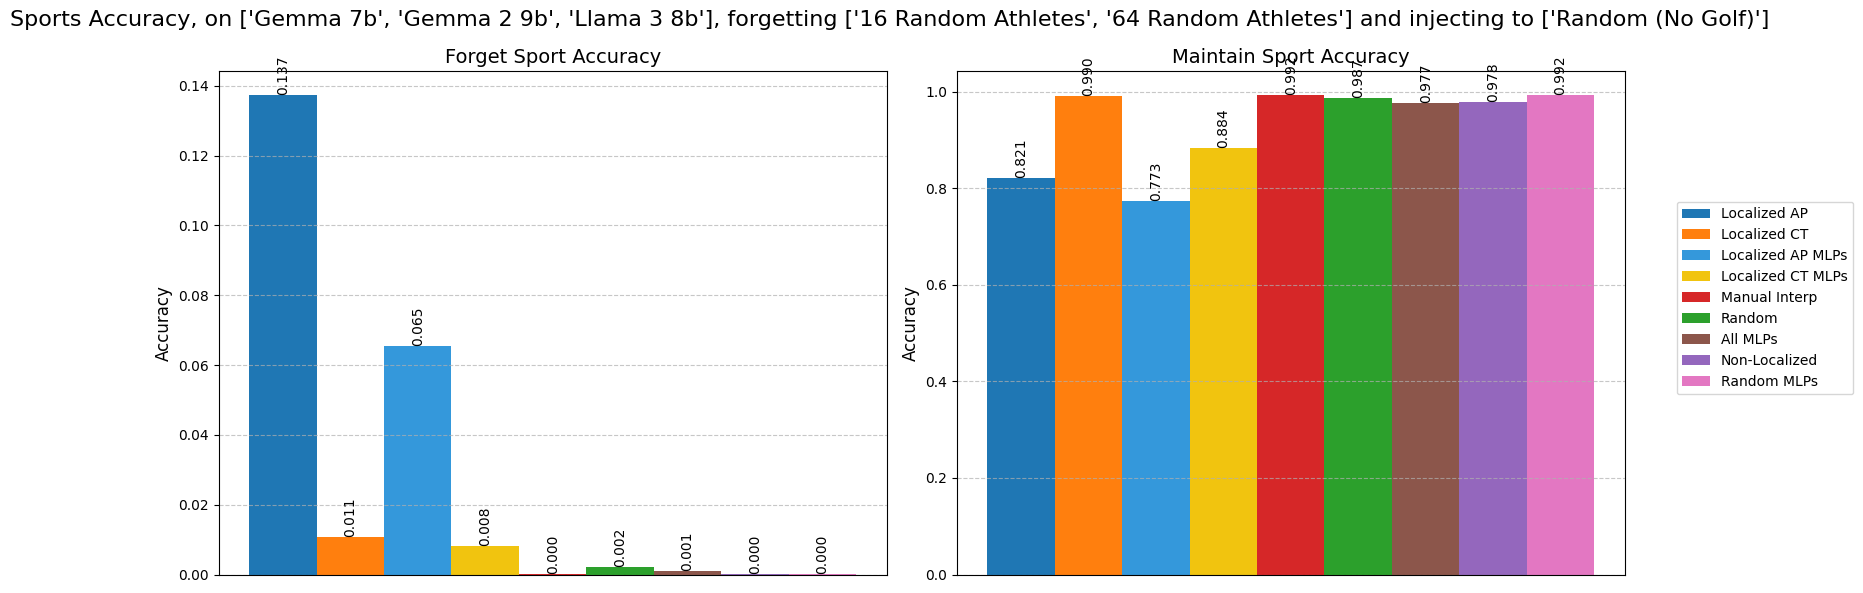

In [6]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

loc_types = test_losses_df['localization_type'].unique()
width = 0.12
x = np.arange(1)  # Only one bar position per subplot

# Plot Forget Sport Accuracy
for idx, loc_type in enumerate(loc_types):
    data = test_losses_df[test_losses_df['localization_type'] == loc_type]
    forget_acc = data[data['task_name'] == 'forget_sport_accuracy']['test_loss'].mean()
    
    # Calculate bar position
    bar_position = x + idx*width - (len(loc_types)-1)*width/2
    
    # Create bar
    bar = ax1.bar(bar_position, forget_acc, width, label=loc_type, color=colors[loc_type])
    
    # Add value label
    ax1.text(bar_position[0], forget_acc, f'{forget_acc:.3f}',
             ha='center', va='bottom', rotation=90)

# Plot Maintain Sport Accuracy
for idx, loc_type in enumerate(loc_types):
    data = test_losses_df[test_losses_df['localization_type'] == loc_type]
    maintain_acc = data[data['task_name'] == 'maintain_sport_accuracy']['test_loss'].mean()
    
    # Calculate bar position
    bar_position = x + idx*width - (len(loc_types)-1)*width/2
    
    # Create bar
    bar = ax2.bar(bar_position, maintain_acc, width, label=loc_type, color=colors[loc_type])
    
    # Add value label
    ax2.text(bar_position[0], maintain_acc, f'{maintain_acc:.3f}',
             ha='center', va='bottom', rotation=90)

# Customize plots
ax1.set_ylabel('Accuracy', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Forget Sport Accuracy', fontsize=14)
ax2.set_title('Maintain Sport Accuracy', fontsize=14)
plt.suptitle(f"Sports Accuracy, on {list(model_names.values())}, forgetting {list(forget_splits.values())} and injecting to {list(inject_labels.values())}", fontsize=16)

# Remove x ticks
ax1.set_xticks([])
ax2.set_xticks([])

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle='--', alpha=0.7)

# Add single legend to the right
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

### Adversarial Evals

In [7]:
adversarial_evals_df.groupby(["localization_type", "eval_type"]).mean(numeric_only=True)

forget  maintain
localization_type eval_type                          
All MLPs          MC               0.228073  0.429436
                  MC_Injected      0.245667  0.090179
                  Normal           0.060409  0.852640
                  Normal_Injected  0.913729  0.075045
Localized AP      MC               0.715539  0.711924
                  MC_Injected      0.082390  0.089065
                  Normal           0.196181  0.730513
                  Normal_Injected  0.775644  0.144161
Localized AP MLPs MC               0.892178  0.884351
                  MC_Injected      0.031726  0.045085
                  Normal           0.198814  0.659214
                  Normal_Injected  0.745878  0.176076
Localized CT      MC               0.423378  0.472154
                  MC_Injected      0.151790  0.113931
                  Normal           0.099565  0.846674
                  Normal_Injected  0.892720  0.078594
Localized CT MLPs MC               0.372572  0.660362
                  MC_Injected      0.370678  0.080629
                  Normal           0.040284  0.809993
                  Normal_Injected  0.938068  0.098441
Manual Interp     MC               0.033079  0.798805
                  MC_Injected      0.862258  0.054006
                  Normal           0.005507  0.972054
                  Normal_Injected  0.988621  0.015893
Non-Localized     MC               0.266036  0.466301
                  MC_Injected      0.326602  0.146840
                  Normal           0.028293  0.924456
                  Normal_Injected  0.962983  0.040965
Random            MC               0.127608  0.369342
                  MC_Injected      0.303413  0.088854
                  Normal           0.036952  0.868278
                  Normal_Injected  0.943306  0.067483
Random MLPs       MC               0.199997  0.804509
                  MC_Injected      0.632253  0.071282
                  Normal           0.051658  0.891139
                  Normal_Injected  0.926200  0.049172

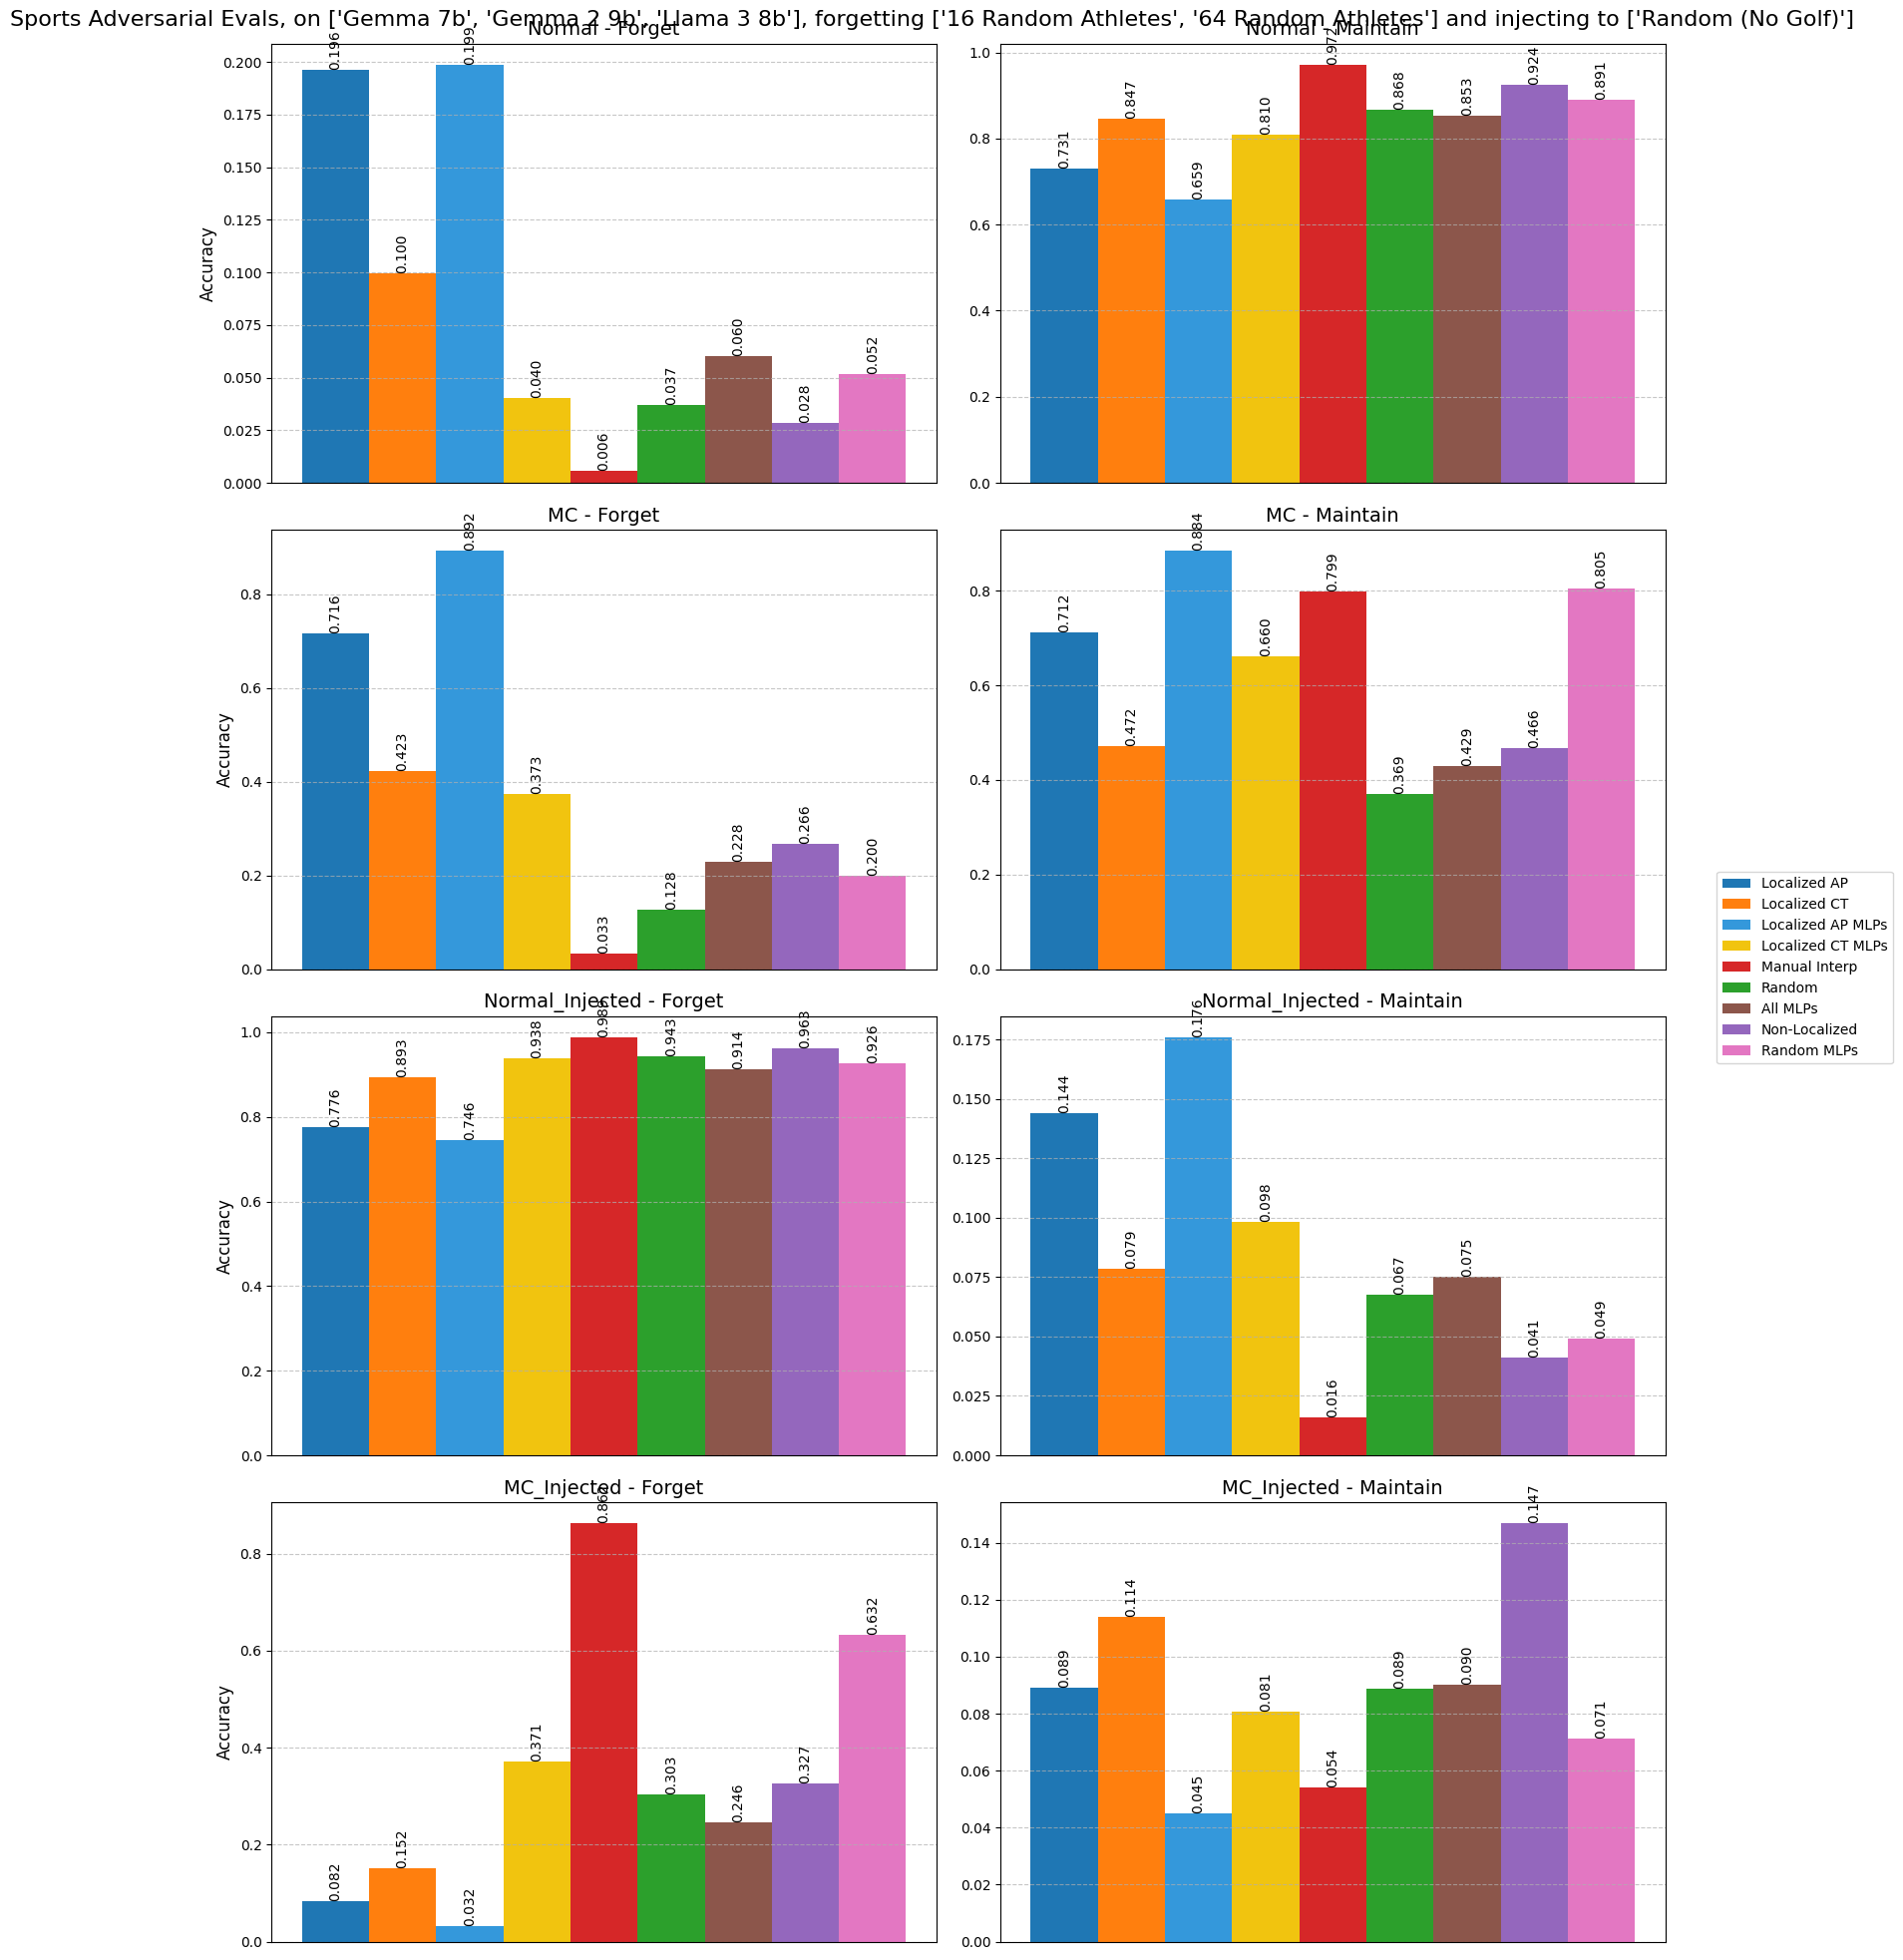

In [8]:
# Create figure and subplots - one row for each eval_type
eval_types = adversarial_evals_df['eval_type'].unique()
fig, axes = plt.subplots(len(eval_types), 2, figsize=(15, 5*len(eval_types)))

loc_types = adversarial_evals_df['localization_type'].unique()
width = 0.12
x = np.arange(1)  # Single bar position per subplot

# Plot each eval_type in a row
for row_idx, eval_type in enumerate(eval_types):
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == eval_type]
    
    # Plot Forget Accuracy (left column)
    for idx, loc_type in enumerate(loc_types):
        loc_data = data[data['localization_type'] == loc_type]
        forget_acc = loc_data['forget'].mean()
        
        # Calculate bar position
        bar_position = x + idx*width - (len(loc_types)-1)*width/2
        
        # Create bar
        bar = axes[row_idx, 0].bar(bar_position, forget_acc, width, 
                                  label=loc_type, color=colors[loc_type])
        
        # Add value label
        axes[row_idx, 0].text(bar_position[0], forget_acc, f'{forget_acc:.3f}',
                             ha='center', va='bottom', rotation=90)
    
    # Plot Maintain Accuracy (right column)
    for idx, loc_type in enumerate(loc_types):
        loc_data = data[data['localization_type'] == loc_type]
        maintain_acc = loc_data['maintain'].mean()
        
        # Calculate bar position
        bar_position = x + idx*width - (len(loc_types)-1)*width/2
        
        # Create bar
        bar = axes[row_idx, 1].bar(bar_position, maintain_acc, width, 
                                  label=loc_type, color=colors[loc_type])
        
        # Add value label
        axes[row_idx, 1].text(bar_position[0], maintain_acc, f'{maintain_acc:.3f}',
                             ha='center', va='bottom', rotation=90)
    
    # Customize each subplot
    axes[row_idx, 0].set_ylabel('Accuracy', fontsize=12)
    axes[row_idx, 0].set_title(f'{eval_type} - Forget', fontsize=14)
    axes[row_idx, 1].set_title(f'{eval_type} - Maintain', fontsize=14)
    
    # Remove x ticks
    axes[row_idx, 0].set_xticks([])
    axes[row_idx, 1].set_xticks([])
    
    # Add grid
    axes[row_idx, 0].grid(True, linestyle='--', alpha=0.7)
    axes[row_idx, 1].grid(True, linestyle='--', alpha=0.7)

# Add single legend to the right
plt.suptitle(f"Sports Adversarial Evals, on {list(model_names.values())}, forgetting {list(forget_splits.values())} and injecting to {list(inject_labels.values())}", fontsize=16)
handles, labels = axes[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

### MMLU Evals

In [9]:
mmlu_evals_df.groupby("localization_type").mean(numeric_only=True)

,mmlu
localization_type,
All MLPs,0.634157
Localized AP,0.641457
Localized AP MLPs,0.642905
Localized CT,0.634513
Localized CT MLPs,0.640341
Manual Interp,0.640483
Non-Localized,0.633955
Random,0.629136
Random MLPs,0.637563


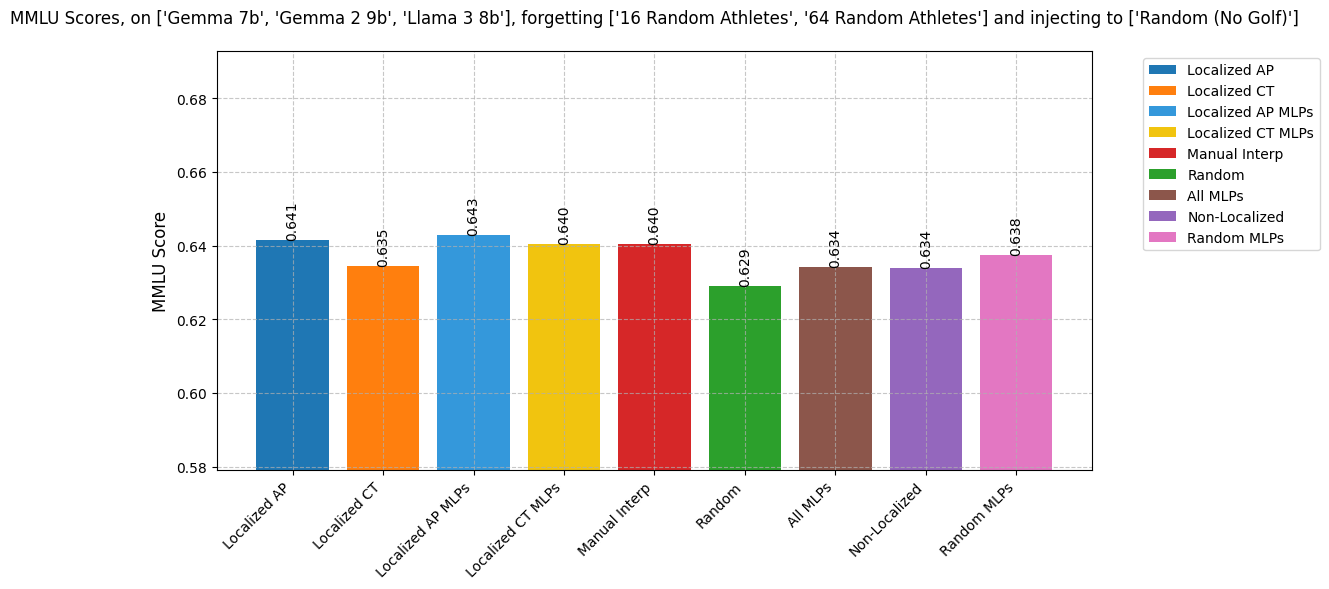

In [10]:
# Create figure
plt.figure(figsize=(12, 6))

# Get data
loc_types = mmlu_evals_df['localization_type'].unique()
mmlu_scores = [mmlu_evals_df[mmlu_evals_df['localization_type'] == loc_type]['mmlu'].mean() 
               for loc_type in loc_types]

# Create bars
bars = plt.bar(range(len(loc_types)), mmlu_scores, color=[colors[loc_type] for loc_type in loc_types])

# Add value labels above each bar
for idx, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=90)

# Customize plot
plt.ylabel('MMLU Score', fontsize=12)
plt.title(f'MMLU Scores, on {list(model_names.values())}, forgetting {list(forget_splits.values())} and injecting to {list(inject_labels.values())}', fontsize=12, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis labels
plt.xticks(range(len(loc_types)), loc_types, rotation=45, ha='right')

# Set y-axis limits
min_score = min(mmlu_scores) - 0.05
max_score = max(mmlu_scores) + 0.05
plt.ylim(min_score, max_score)

# Add legend
plt.legend(bars, loc_types, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

plt.show()

### Probing Evals

In [11]:
if do_probing_evals:
    probing_evals_df.groupby(["localization_type", "layer"])[["forget_ground_truth_acc", "forget_edit_acc"]].mean(numeric_only=True)

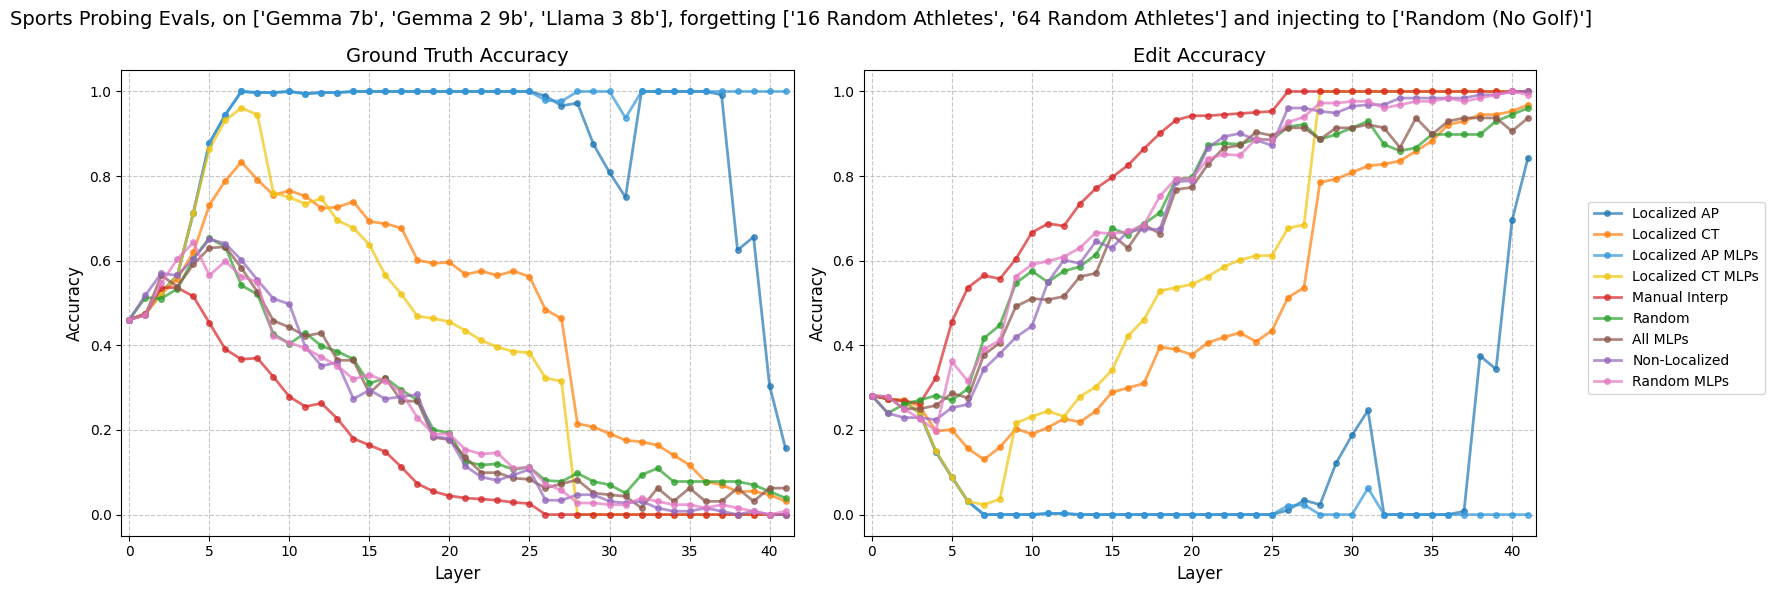

In [12]:
if do_probing_evals:
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    loc_types = probing_evals_df['localization_type'].unique()
    layers = probing_evals_df['layer'].unique()

    # Plot Ground Truth Accuracy
    for loc_type in loc_types:
        data = probing_evals_df[probing_evals_df['localization_type'] == loc_type]
        ground_truth_vals = [data[data['layer'] == layer]['forget_ground_truth_acc'].mean() 
                            for layer in layers]
        
        ax1.plot(layers, ground_truth_vals, 'o-', label=loc_type, 
                color=colors[loc_type], alpha=0.7, markersize=4, linewidth=2)

    # Plot Edit Accuracy
    for loc_type in loc_types:
        data = probing_evals_df[probing_evals_df['localization_type'] == loc_type]
        edit_vals = [data[data['layer'] == layer]['forget_edit_acc'].mean() 
                    for layer in layers]
        
        ax2.plot(layers, edit_vals, 'o-', label=loc_type, 
                color=colors[loc_type], alpha=0.7, markersize=4, linewidth=2)

    # Customize plots
    for ax, title in zip([ax1, ax2], ['Ground Truth Accuracy', 'Edit Accuracy']):
        ax.set_xlabel('Layer', fontsize=12)
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(-0.5, len(layers)-0.5)

    plt.suptitle(f"Sports Probing Evals, on {list(model_names.values())}, forgetting {list(forget_splits.values())} and injecting to {list(inject_labels.values())}", fontsize=14)
    # Add single legend to the right
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')

    # Adjust layout
    plt.tight_layout()

    plt.show()

### Softprompt Evals

In [13]:
softprompt_evals_df.groupby(["localization_type"]).mean(numeric_only=True).drop("softprompt_iter", axis=1)

,forget_acc,forget_acc_with_injected,maintain_acc
localization_type,,,
All MLPs,0.336804,0.399621,0.428557
Localized AP,0.382184,0.363110,0.502870
Localized AP MLPs,0.387005,0.381652,0.543200
Localized CT,0.377757,0.374367,0.520737
Localized CT MLPs,0.352043,0.377882,0.471994
Manual Interp,0.326889,0.358726,0.443042
Non-Localized,0.301367,0.418109,0.451011
Random,0.345005,0.354437,0.478886
Random MLPs,0.375620,0.334191,0.463333


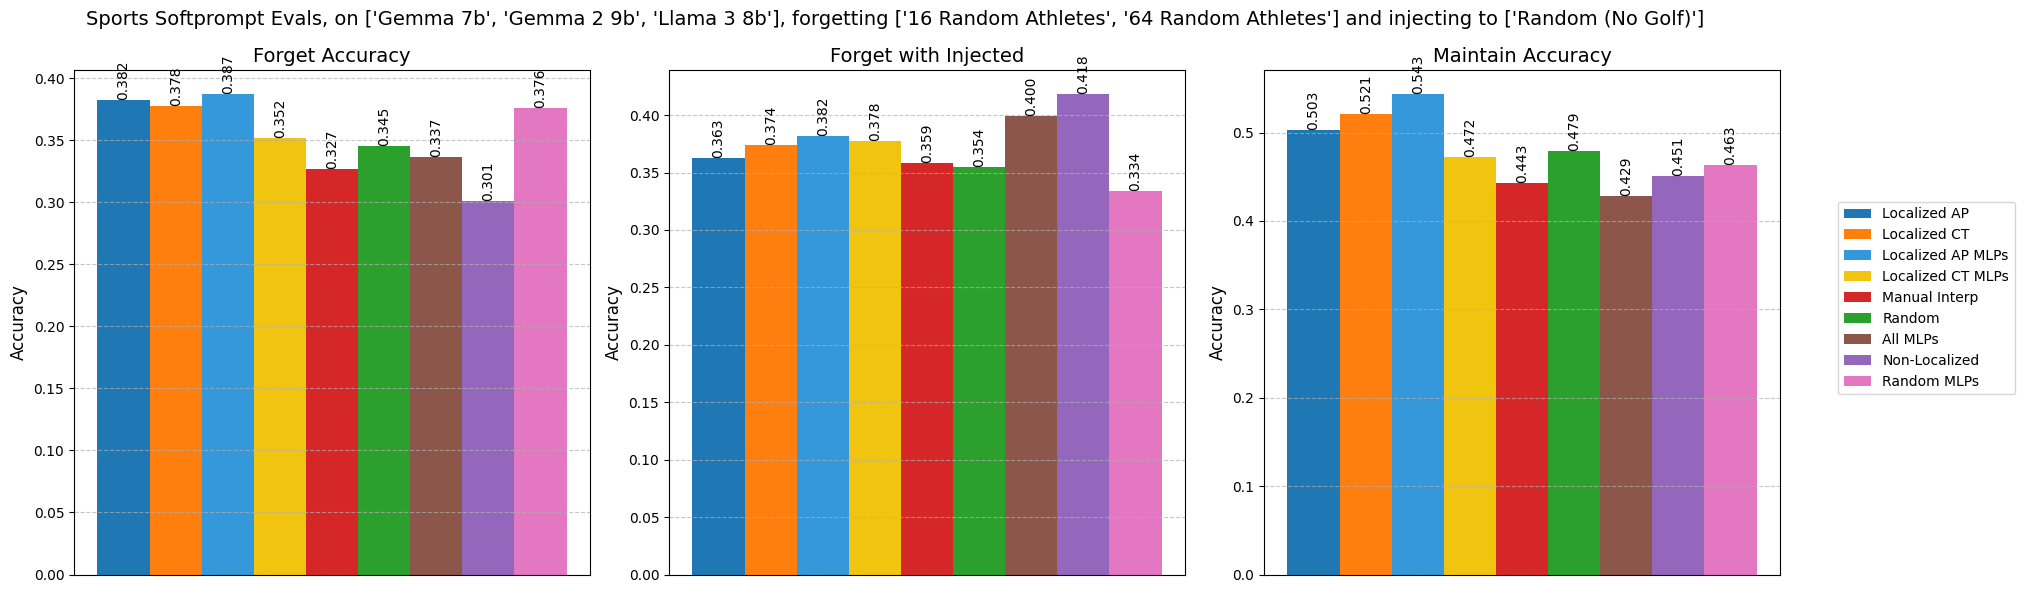

In [14]:
# Create figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

loc_types = softprompt_evals_df['localization_type'].unique()
width = 0.12
x = np.arange(1)  # Single bar position per subplot

# Plot Forget Accuracy
for idx, loc_type in enumerate(loc_types):
    data = softprompt_evals_df[softprompt_evals_df['localization_type'] == loc_type]
    forget_acc = data['forget_acc'].mean()
    
    # Calculate bar position
    bar_position = x + idx*width - (len(loc_types)-1)*width/2
    
    # Create bar
    bar = ax1.bar(bar_position, forget_acc, width, label=loc_type, color=colors[loc_type])
    
    # Add value label
    ax1.text(bar_position[0], forget_acc, f'{forget_acc:.3f}',
             ha='center', va='bottom', rotation=90)

# Plot Forget with Injected Accuracy
for idx, loc_type in enumerate(loc_types):
    data = softprompt_evals_df[softprompt_evals_df['localization_type'] == loc_type]
    forget_injected_acc = data['forget_acc_with_injected'].mean()
    
    # Calculate bar position
    bar_position = x + idx*width - (len(loc_types)-1)*width/2
    
    # Create bar
    bar = ax2.bar(bar_position, forget_injected_acc, width, label=loc_type, color=colors[loc_type])
    
    # Add value label
    ax2.text(bar_position[0], forget_injected_acc, f'{forget_injected_acc:.3f}',
             ha='center', va='bottom', rotation=90)

# Plot Maintain Accuracy
for idx, loc_type in enumerate(loc_types):
    data = softprompt_evals_df[softprompt_evals_df['localization_type'] == loc_type]
    maintain_acc = data['maintain_acc'].mean()
    
    # Calculate bar position
    bar_position = x + idx*width - (len(loc_types)-1)*width/2
    
    # Create bar
    bar = ax3.bar(bar_position, maintain_acc, width, label=loc_type, color=colors[loc_type])
    
    # Add value label
    ax3.text(bar_position[0], maintain_acc, f'{maintain_acc:.3f}',
             ha='center', va='bottom', rotation=90)

# Customize plots
for ax, title in zip([ax1, ax2, ax3], ['Forget Accuracy', 'Forget with Injected', 'Maintain Accuracy']):
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks([])
    ax.grid(True, linestyle='--', alpha=0.7)

# Add single legend to the right
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.suptitle(f"Sports Softprompt Evals, on {list(model_names.values())}, forgetting {list(forget_splits.values())} and injecting to {list(inject_labels.values())}", fontsize=14)
# Adjust layout
plt.tight_layout()

plt.show()

### Relearning Evals

In [15]:
relearning_evals_df.groupby(["localization_type", "step"]).mean(numeric_only=True)[["Normal_Injected_forget", "MC_Injected_forget"]]

Normal_Injected_forget  MC_Injected_forget
localization_type step                                            
All MLPs          0                   0.998523            0.230343
                  10                  0.543327            0.192021
                  20                  0.567030            0.190671
Localized AP      0                   0.847120            0.101164
                  10                  0.197623            0.154191
                  20                  0.124662            0.158739
Localized AP MLPs 0                   0.916104            0.043829
                  10                  0.095184            0.044118
                  20                  0.062251            0.041265
Localized CT      0                   0.990322            0.099451
                  10                  0.531138            0.148306
                  20                  0.454365            0.151878
Localized CT MLPs 0                   0.990241            0.361575
                  10                  0.317184            0.303736
                  20                  0.307359            0.311955
Manual Interp     0                   0.999948            0.617720
                  10                  0.493288            0.328043
                  20                  0.644878            0.328039
Non-Localized     0                   0.999582            0.203930
                  10                  0.509887            0.190184
                  20                  0.525210            0.200365
Random            0                   0.993363            0.204465
                  10                  0.570178            0.166375
                  20                  0.542015            0.191443
Random MLPs       0                   0.999850            0.521608
                  10                  0.573930            0.442735
                  20                  0.654911            0.454610

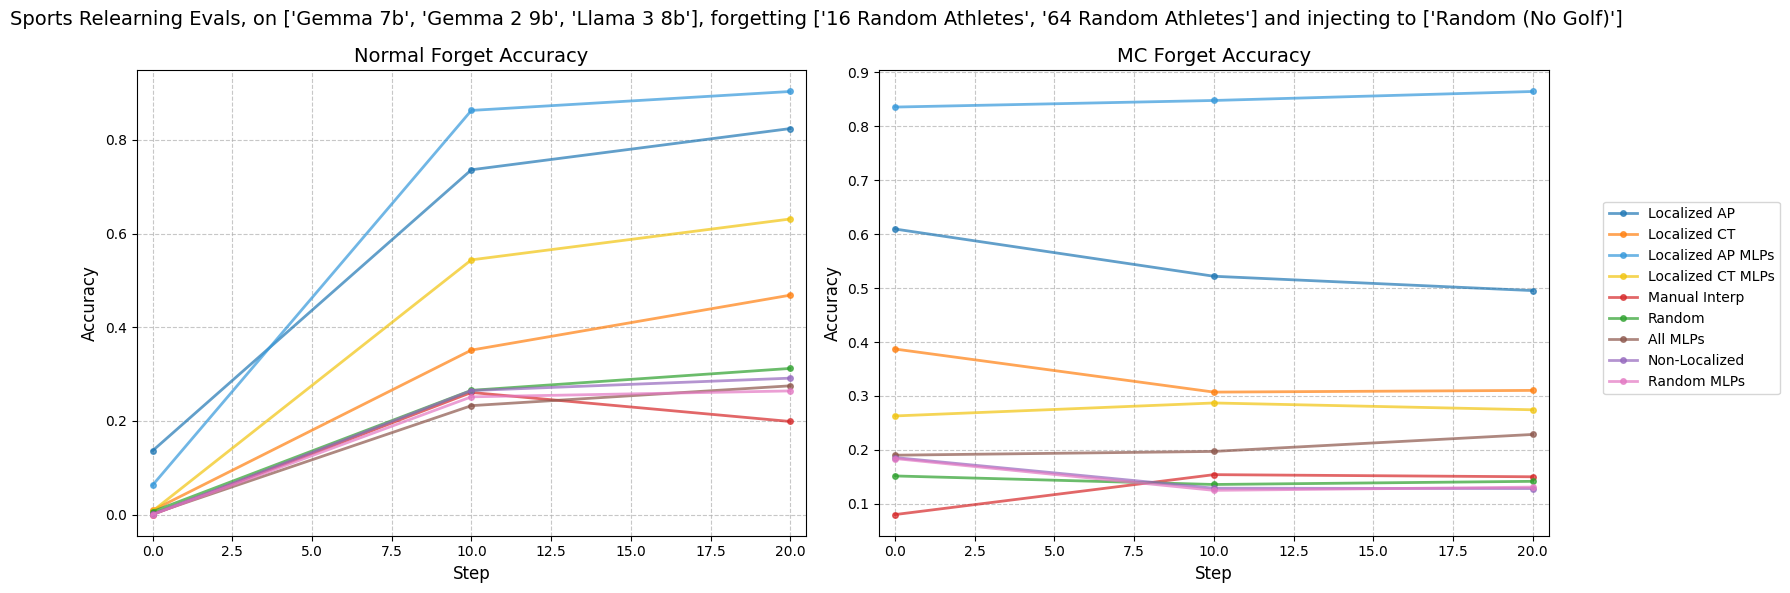

In [16]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

loc_types = relearning_evals_df['localization_type'].unique()
steps = relearning_evals_df['step'].unique()

# Plot Normal Injected Forget
for loc_type in loc_types:
    data = relearning_evals_df[relearning_evals_df['localization_type'] == loc_type]
    normal_forget_vals = [data[data['step'] == step]['Normal_forget'].mean() 
                           for step in steps]
    
    ax1.plot(steps, normal_forget_vals, 'o-', label=loc_type, 
             color=colors[loc_type], alpha=0.7, markersize=4, linewidth=2)

# Plot MC Injected Forget
for loc_type in loc_types:
    data = relearning_evals_df[relearning_evals_df['localization_type'] == loc_type]
    mc_forget_vals = [data[data['step'] == step]['MC_forget'].mean() 
                        for step in steps]
    
    ax2.plot(steps, mc_forget_vals, 'o-', label=loc_type, 
             color=colors[loc_type], alpha=0.7, markersize=4, linewidth=2)

# Customize plots
for ax, title in zip([ax1, ax2], ['Normal Forget Accuracy', 'MC Forget Accuracy']):
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(-0.5, max(steps)+0.5)

# Add single legend to the right
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.suptitle(f"Sports Relearning Evals, on {list(model_names.values())}, forgetting {list(forget_splits.values())} and injecting to {list(inject_labels.values())}", fontsize=14)
# Adjust layout
plt.tight_layout()

plt.show()

## Paper Graphs

Accuracies After Editing Random Sets of Athletes


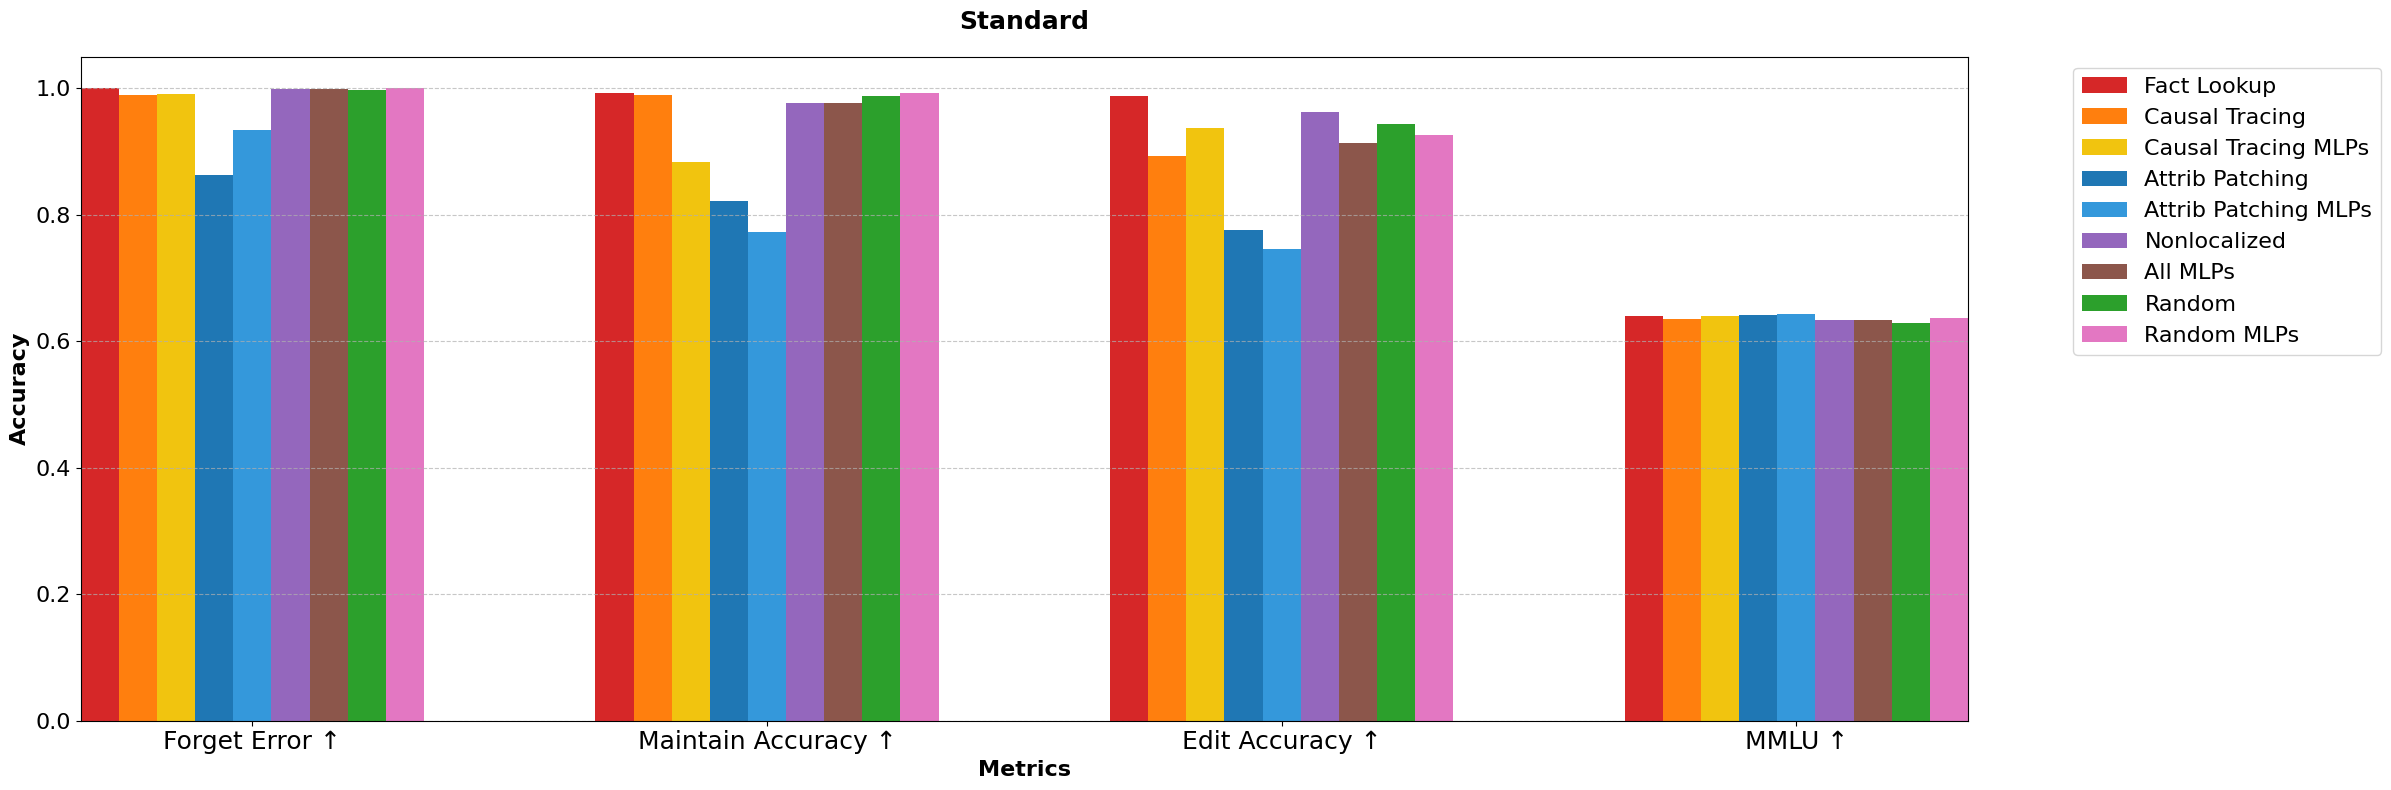

Multiple Choice Accuracies After Editing Random Sets of Athletes


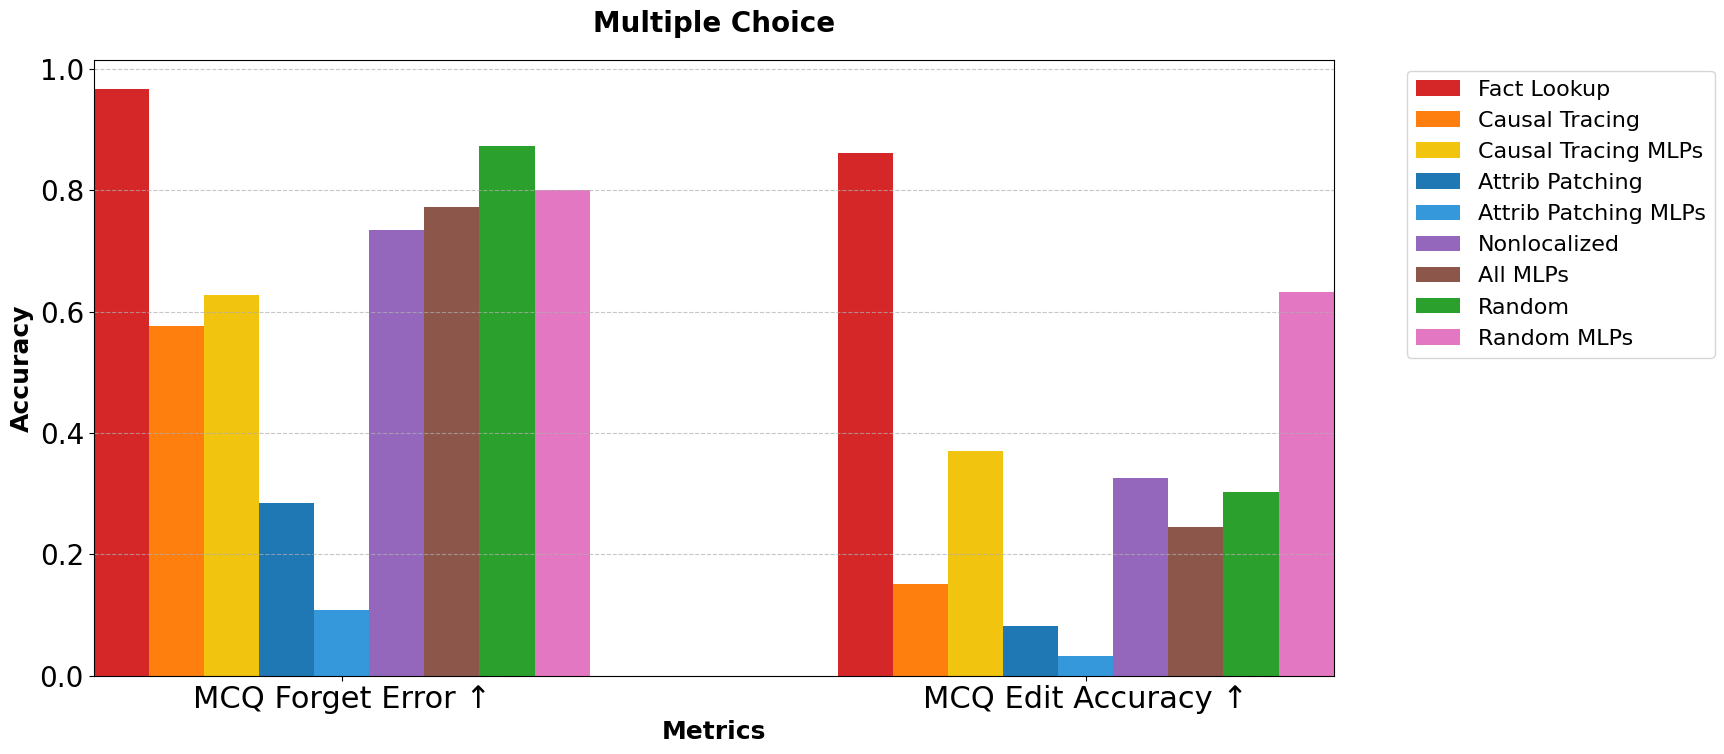

In [17]:
# colors = {"localized_ap": "#e74c3c", "localized_ct": "#2ecc71", "localized_ap_mlps": "#3498db", "localized_ct_mlps": "#f1c40f", "manual_interp": "#9b59b6", "random": "#1abc9c", "all_mlps": "#e67e22", "nonlocalized": "#e74c3c", "random_mlps": "#2ecc71"}
paper_locs = {"Manual Interp": "Fact Lookup", "Localized CT": "Causal Tracing", "Localized CT MLPs": "Causal Tracing MLPs", "Localized AP": "Attrib Patching", "Localized AP MLPs": "Attrib Patching MLPs", "Non-Localized": "Nonlocalized", "All MLPs": "All MLPs", "Random": "Random", "Random MLPs": "Random MLPs"}


include_bar_text = False
# First plot - Vanilla metrics + MMLU
plt.figure(figsize=(24, 8))
vanilla_metrics = ['Forget Error ↑', 'Maintain Accuracy ↑', 'Edit Accuracy ↑', 'MMLU ↑']
n_locs = len(paper_locs)
width = 1 / len(paper_locs)
spacing = 1.5

x1 = np.arange(0, len(vanilla_metrics) * spacing, spacing)
for idx, (loc_type, loc_name) in enumerate(paper_locs.items()):
    # Collect vanilla accuracies
    accuracies = []
    
    # vanilla forget sport accuracy
    data = test_losses_df[test_losses_df['localization_type'] == loc_type]
    forget_acc = 1 - data[data['task_name'] == 'forget_sport_accuracy']['test_loss'].mean()
    accuracies.append(forget_acc)
    
    # vanilla maintain sport accuracy
    maintain_acc = data[data['task_name'] == 'maintain_sport_accuracy']['test_loss'].mean()
    accuracies.append(maintain_acc)
    
    # vanilla edit sport accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "Normal_Injected"]
    edit_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    accuracies.append(edit_acc)
    
    # MMLU accuracy
    mmlu_acc = mmlu_evals_df[mmlu_evals_df['localization_type'] == loc_type]['mmlu'].mean()
    accuracies.append(mmlu_acc)
    
    # Plot bars
    offset = width * (idx - n_locs/2 + 0.5)
    bars = plt.bar(x1 + offset, accuracies, width, label=loc_name, color=colors[loc_type])
    
    # Add value labels
    if include_bar_text:
        for i, v in enumerate(accuracies):
            plt.text(x1[i] + offset, v, f'{v:.3f}', ha='center', va='bottom', rotation=90, fontsize=14)

plt.xlabel('Metrics', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')

if "random_without_golf" in inject_labels:
    title = 'Accuracies After Editing Random Sets of Athletes'
else:
    title = 'Accuracies After Editing Whole Sports'
print(title)
plt.title("Standard", fontsize=18, fontweight='bold', pad=20)
plt.xticks(x1, vanilla_metrics, fontsize=18)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.xlim(min(x1) - 0.5, max(x1) + 0.5)

# Add legend
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Second plot - MC metrics
plt.figure(figsize=(16, 8))
mc_metrics = ['MCQ Forget Error ↑', 'MCQ Edit Accuracy ↑']

x2 = np.arange(0, len(mc_metrics) * spacing, spacing)
for idx, (loc_type, loc_name) in enumerate(paper_locs.items()):
    # Collect MC accuracies
    accuracies = []
    
    # mc forget accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "MC"]
    mc_forget_acc = 1 - data[data['localization_type'] == loc_type]['forget'].mean()
    accuracies.append(mc_forget_acc)
    
    # mc edit accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "MC_Injected"]
    mc_edit_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    accuracies.append(mc_edit_acc)
    
    # Plot bars
    offset = width * (idx - n_locs/2 + 0.5)
    bars = plt.bar(x2 + offset, accuracies, width, label=loc_name, color=colors[loc_type])
    
    # Add value labels
    if include_bar_text:
        for i, v in enumerate(accuracies):
            plt.text(x2[i] + offset, v, f'{v:.3f}', ha='center', va='bottom', rotation=90, fontsize=14)

plt.xlabel('Metrics', fontsize=18, fontweight='bold')
plt.ylabel('Accuracy', fontsize=18, fontweight='bold')
if "random_without_golf" in inject_labels:
    title = 'Multiple Choice Accuracies After Editing Random Sets of Athletes'
else:
    title = 'Multiple Choice Accuracies After Editing Whole Sports'
print(title)
title = "Multiple Choice"
plt.title(title, fontsize=20, fontweight='bold', pad=20)
plt.xticks(x2, mc_metrics, fontsize=22)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.xlim(min(x2) - 0.5, max(x2) + 0.5)

# Add legend
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
plt.show()

### Spider

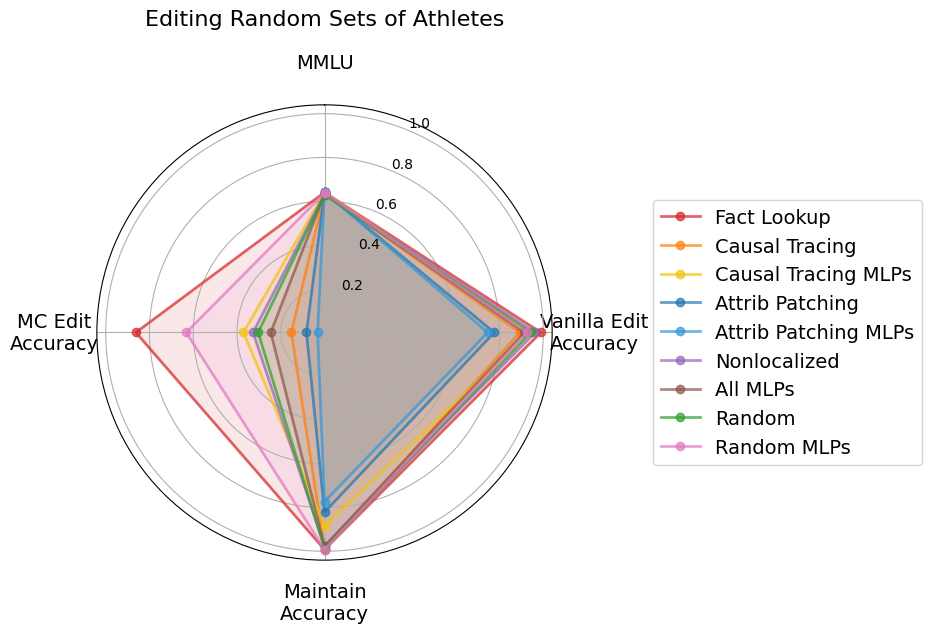

In [18]:
import numpy as np

# Create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

# Define the metrics we want to show
metrics = ['MMLU', 'Vanilla Edit\nAccuracy', 'Maintain\nAccuracy', 'MC Edit\nAccuracy']
num_metrics = len(metrics)

# Calculate angles for each metric
angles = [n / float(num_metrics) * 2 * np.pi for n in range(num_metrics)]
angles += angles[:1]  # Complete the circle

# Get data for each localization type
for loc_type, loc_name in paper_locs.items():
    values = []
    
    # MMLU accuracy
    mmlu_acc = mmlu_evals_df[mmlu_evals_df['localization_type'] == loc_type]['mmlu'].mean()
    values.append(mmlu_acc)
    
    # Vanilla edit accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "Normal_Injected"]
    edit_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    values.append(edit_acc)
    
    # Maintain accuracy
    data = test_losses_df[test_losses_df['localization_type'] == loc_type]
    maintain_acc = data[data['task_name'] == 'maintain_sport_accuracy']['test_loss'].mean()
    values.append(maintain_acc)
    
    # MC edit accuracy
    data = adversarial_evals_df[adversarial_evals_df['eval_type'] == "MC_Injected"]
    mc_edit_acc = data[data['localization_type'] == loc_type]['forget'].mean()
    values.append(mc_edit_acc)
    
    # Complete the circle
    values += values[:1]
    
    # Plot the values
    ax.plot(angles, values, 'o-', linewidth=2, label=loc_name, color=colors[loc_type], alpha=0.7)
    ax.fill(angles, values, alpha=0.1, color=colors[loc_type])

# Fix axis to go in the right order and start at the top
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=14)

# Increase the spacing between labels and plot
ax.tick_params(pad=20)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), fontsize=14)

if "random_without_golf" in inject_labels:
    title = 'Editing Random Sets of Athletes'
else:
    title = 'Editing Whole Sports'
plt.title(title, fontsize=16, pad=20)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

### Probing

Probes to Determine Which Answers are Latently Represented, after editing random sets of athletes
gemma


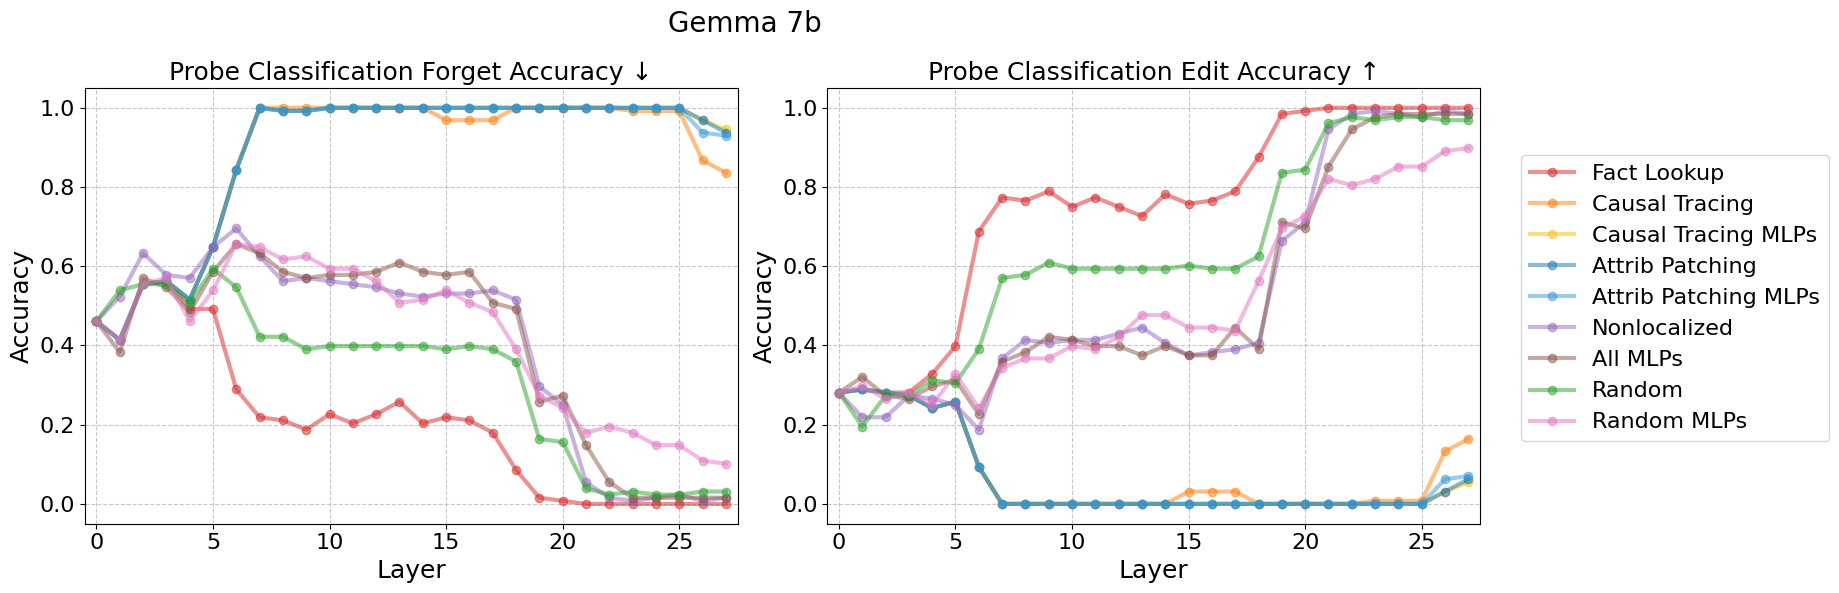

Probes to Determine Which Answers are Latently Represented, after editing random sets of athletes
gemma2


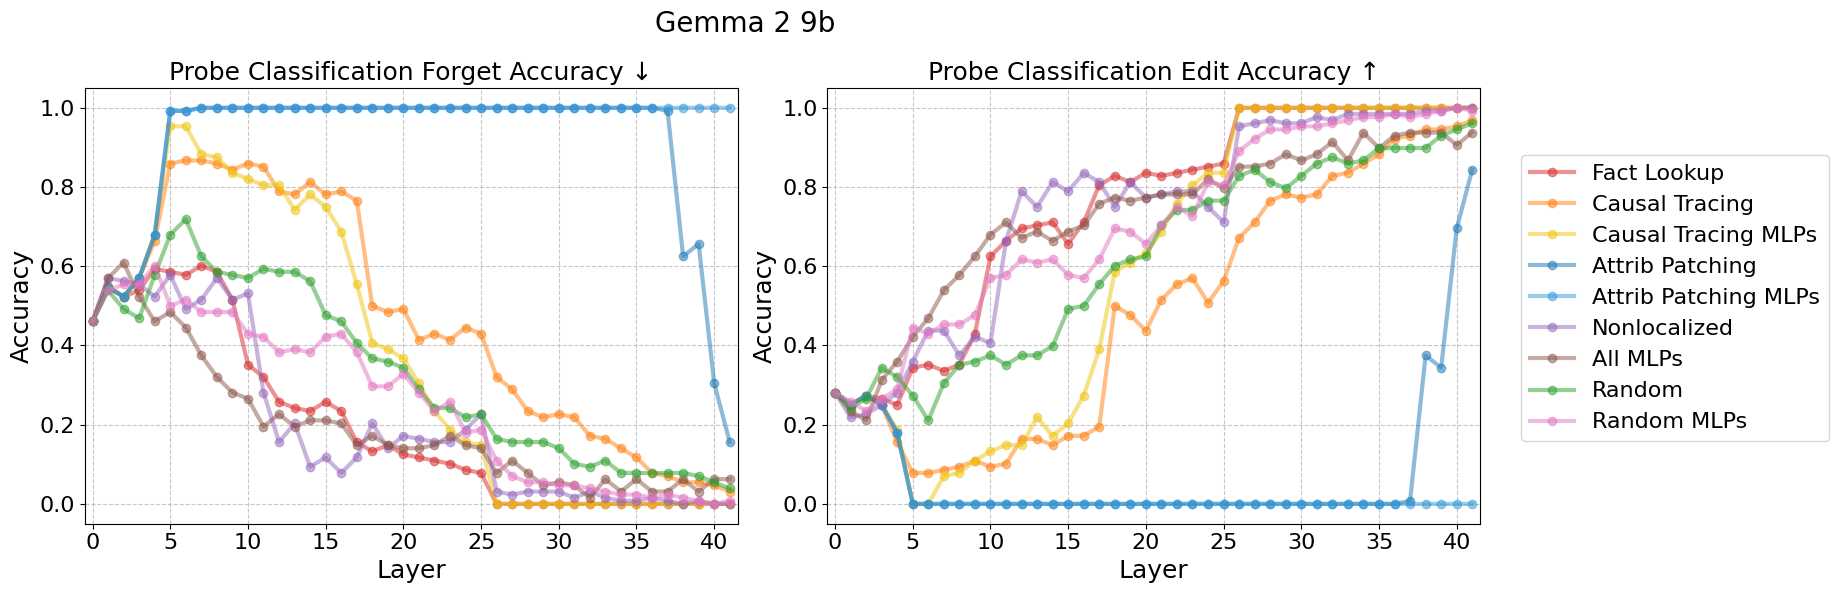

Probes to Determine Which Answers are Latently Represented, after editing random sets of athletes
llama3


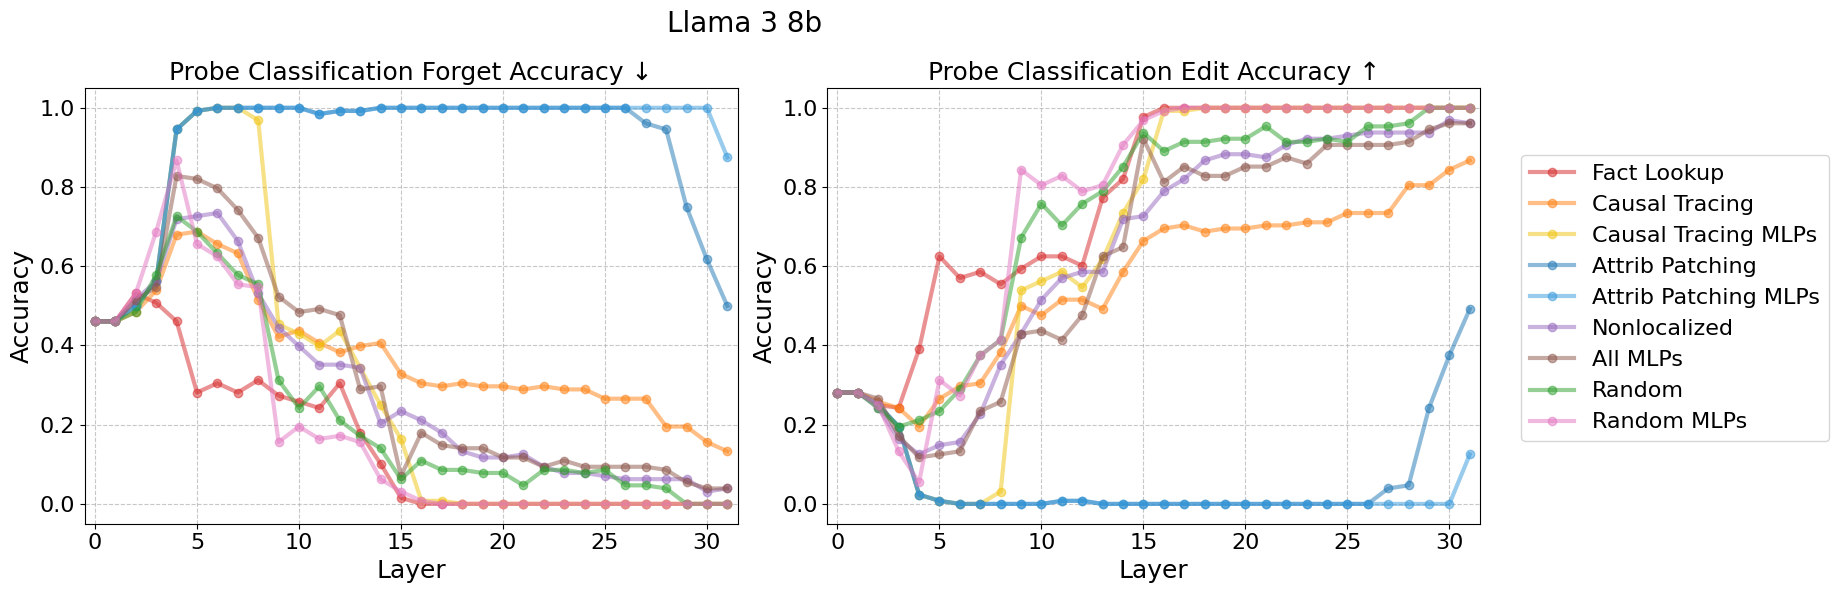

In [19]:
for model_type in model_names:

    model_probing_evals_df = probing_evals_df[probing_evals_df['model_name'] == model_type]
    if do_probing_evals:
        # Create figure and subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        loc_types = model_probing_evals_df['localization_type'].unique()
        layers = model_probing_evals_df['layer'].unique()

        # Plot Ground Truth Accuracy
        for loc_type in paper_locs:
            data = model_probing_evals_df[model_probing_evals_df['localization_type'] == loc_type]
            ground_truth_vals = [data[data['layer'] == layer]['forget_ground_truth_acc'].mean() 
                                for layer in layers]
            
            ax1.plot(layers, ground_truth_vals, 'o-', label=paper_locs[loc_type], 
                    color=colors[loc_type], alpha=0.5, markersize=6, linewidth=3)

        # Plot Edit Accuracy
        for loc_type in paper_locs:
            data = model_probing_evals_df[model_probing_evals_df['localization_type'] == loc_type]
            edit_vals = [data[data['layer'] == layer]['forget_edit_acc'].mean() 
                        for layer in layers]
            
            ax2.plot(layers, edit_vals, 'o-', label=paper_locs[loc_type], 
                    color=colors[loc_type], alpha=0.5, markersize=6, linewidth=3)

        # Customize plots 
        for ax, title in zip([ax1, ax2], ['Probe Classification Forget Accuracy ↓', 'Probe Classification Edit Accuracy ↑']): 
            ax.set_xlabel('Layer', fontsize=18)
            ax.set_ylabel('Accuracy', fontsize=18)
            ax.set_title(title, fontsize=18)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_xlim(-0.5, len(layers)-0.5)
            # Increase tick label sizes
            ax.tick_params(axis='both', which='major', labelsize=16)

        if "random_without_golf" in inject_labels:
            title = 'Probes to Determine Which Answers are Latently Represented, after editing random sets of athletes'
        else:
            title = 'Probes to Determine Which Answers are Latently Represented, after editing whole sports'
        print(title)
        print(model_type)
        plt.suptitle(model_names[model_type], fontsize=20) # , y=1.05
        
        # Add single legend to the right with larger font
        handles, labels = ax2.get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=16)

        # Adjust layout with more space for title
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # Make room for suptitle

        plt.show()

Probes to Determine Which Answers are Latently Represented, after editing random sets of athletes


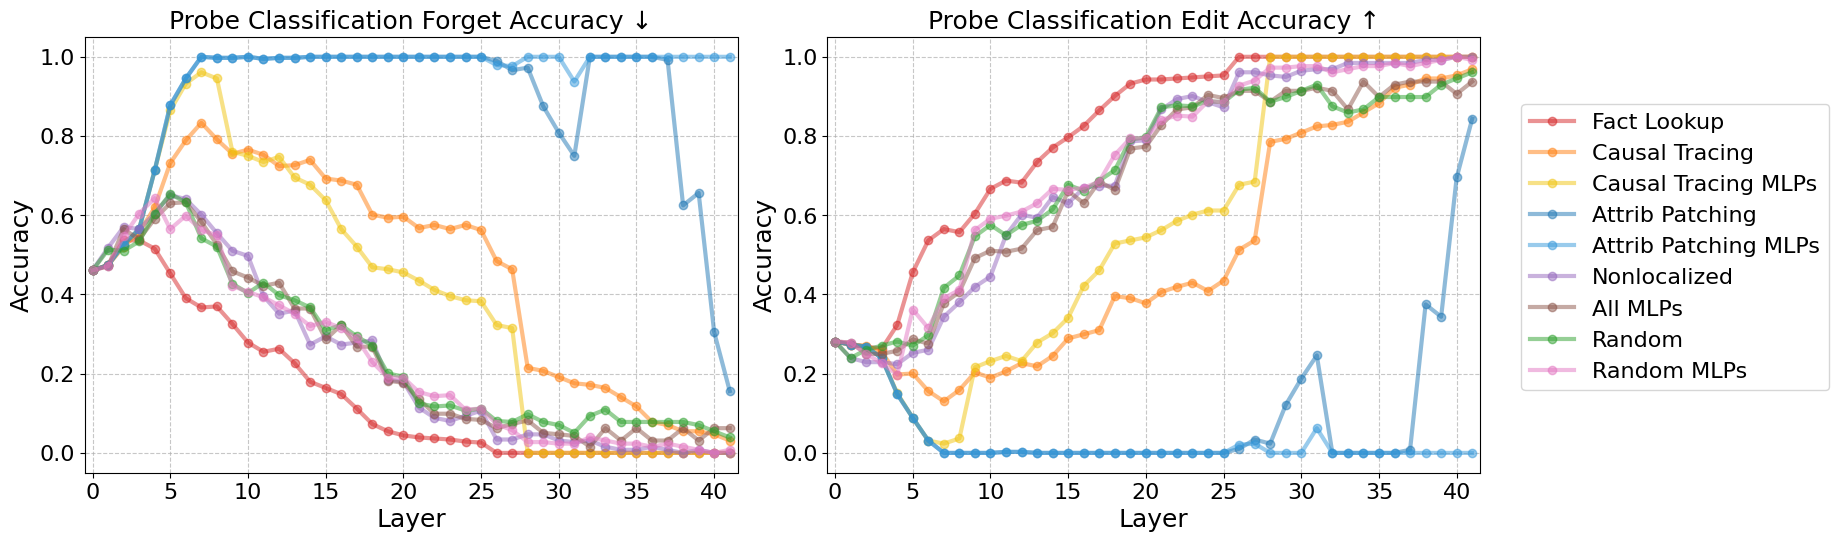

In [20]:
if do_probing_evals:
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    loc_types = probing_evals_df['localization_type'].unique()
    layers = probing_evals_df['layer'].unique()

    # Plot Ground Truth Accuracy
    for loc_type in paper_locs:
        data = probing_evals_df[probing_evals_df['localization_type'] == loc_type]
        ground_truth_vals = [data[data['layer'] == layer]['forget_ground_truth_acc'].mean() 
                            for layer in layers]
        
        ax1.plot(layers, ground_truth_vals, 'o-', label=paper_locs[loc_type], 
                color=colors[loc_type], alpha=0.5, markersize=6, linewidth=3)

    # Plot Edit Accuracy
    for loc_type in paper_locs:
        data = probing_evals_df[probing_evals_df['localization_type'] == loc_type]
        edit_vals = [data[data['layer'] == layer]['forget_edit_acc'].mean() 
                    for layer in layers]
        
        ax2.plot(layers, edit_vals, 'o-', label=paper_locs[loc_type], 
                color=colors[loc_type], alpha=0.5, markersize=6, linewidth=3)

    # Customize plots 
    for ax, title in zip([ax1, ax2], ['Probe Classification Forget Accuracy ↓', 'Probe Classification Edit Accuracy ↑']): 
        ax.set_xlabel('Layer', fontsize=18)
        ax.set_ylabel('Accuracy', fontsize=18)
        ax.set_title(title, fontsize=18)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(-0.5, len(layers)-0.5)
        # Increase tick label sizes
        ax.tick_params(axis='both', which='major', labelsize=16)

    if "random_without_golf" in inject_labels:
        title = 'Probes to Determine Which Answers are Latently Represented, after editing random sets of athletes'
    else:
        title = 'Probes to Determine Which Answers are Latently Represented, after editing whole sports'
    print(title)
    
    # Add single legend to the right with larger font
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=16)

    # Adjust layout with more space for title
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for suptitle

    plt.show()

In [21]:
# if do_probing_evals:
#     # Create figure and subplots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     loc_types = probing_evals_df['localization_type'].unique()
#     layers = probing_evals_df['layer'].unique()
#     # transform layers
#     max_model_layers = {}
#     for model_type in model_names:
#         max_model_layers[model_type] = probing_evals_df[probing_evals_df['model_name'] == model_type]['layer'].max()
#     def transform_layer(row):
#         return row['layer'] / max_model_layers[row['model_name']]
#     scaled_layers = probing_evals_df.apply(transform_layer, axis=1)

#     # Plot Ground Truth Accuracy
#     for loc_type in paper_locs:
#         data = probing_evals_df[probing_evals_df['localization_type'] == loc_type]
#         ground_truth_vals = [data[data['layer'] == layer]['forget_ground_truth_acc'].mean() 
#                             for layer in layers]
        
#         ax1.plot(scaled_layers, ground_truth_vals, 'o-', label=paper_locs[loc_type], 
#                 color=colors[loc_type], alpha=0.5, markersize=6, linewidth=3)

#     # Plot Edit Accuracy
#     for loc_type in paper_locs:
#         data = probing_evals_df[probing_evals_df['localization_type'] == loc_type]
#         edit_vals = [data[data['layer'] == layer]['forget_edit_acc'].mean() 
#                     for layer in layers]
        
#         ax2.plot(scaled_layers, edit_vals, 'o-', label=paper_locs[loc_type], 
#                 color=colors[loc_type], alpha=0.5, markersize=6, linewidth=3)

#     # Customize plots 
#     for ax, title in zip([ax1, ax2], ['Accuracy Predicting Ground Truth Answers ↓', 'Accuracy Predicting Edited Answers ↑']): 
#         ax.set_xlabel('Layer', fontsize=18)
#         ax.set_ylabel('Accuracy', fontsize=18)
#         ax.set_title(title, fontsize=18)
#         ax.grid(True, linestyle='--', alpha=0.7)
#         ax.set_xlim(-0.5, len(layers)-0.5)
#         # Increase tick label sizes
#         ax.tick_params(axis='both', which='major', labelsize=16)

#     if "random_without_golf" in inject_labels:
#         title = 'Probes to Determine Which Answers are Latently Represented, after editing random sets of athletes'
#     else:
#         title = 'Probes to Determine Which Answers are Latently Represented, after editing whole sports'
#     print(title)
#     print(model_type)
#     plt.suptitle(model_names[model_type], fontsize=20) # , y=1.05
    
#     # Add single legend to the right with larger font
#     handles, labels = ax2.get_legend_handles_labels()
#     fig.legend(handles, labels, bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=16)

#     # Adjust layout with more space for title
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.85)  # Make room for suptitle

#     plt.show()

### Relearning Evals

Recovered Accuracy After Editing Random Sets of Athletes
and Partial Relearning


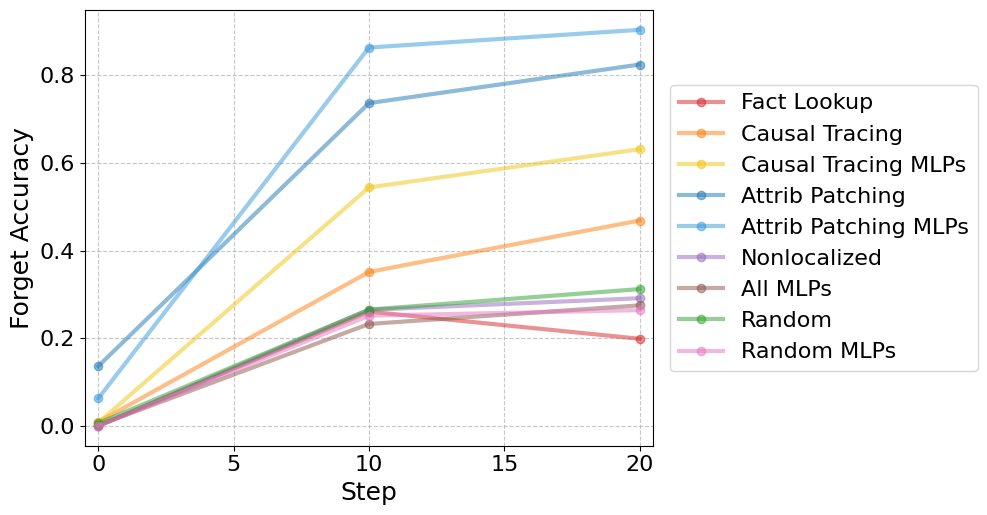

In [22]:
# Create figure with single subplot
fig, ax = plt.subplots(figsize=(10, 6))

steps = relearning_evals_df['step'].unique()

# Plot Normal Forget Accuracy
for loc_type in paper_locs:
    data = relearning_evals_df[relearning_evals_df['localization_type'] == loc_type]
    normal_forget_vals = [data[data['step'] == step]['Normal_forget'].mean() 
                         for step in steps]
    
    ax.plot(steps, normal_forget_vals, 'o-', label=paper_locs[loc_type],
            color=colors[loc_type], alpha=0.5, markersize=6, linewidth=3)

# Customize plot
ax.set_xlabel('Step', fontsize=18)
ax.set_ylabel('Forget Accuracy', fontsize=18)
# ax.set_title('Forget Accuracy', fontsize=18)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlim(-0.5, max(steps)+0.5)
ax.tick_params(axis='both', which='major', labelsize=16)

if "random_without_golf" in inject_labels:
    title = 'Recovered Accuracy After Editing Random Sets of Athletes\nand Partial Relearning'
else:
    title = 'Recovered Accuracy After Editing Whole Sports\nand Partial Relearning'
# plt.suptitle(title, fontsize=20, y=1.05)
print(title)

# Add legend to the right
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Make room for suptitle

plt.show()

Sports Forget Accuracy Recovered by Relearning


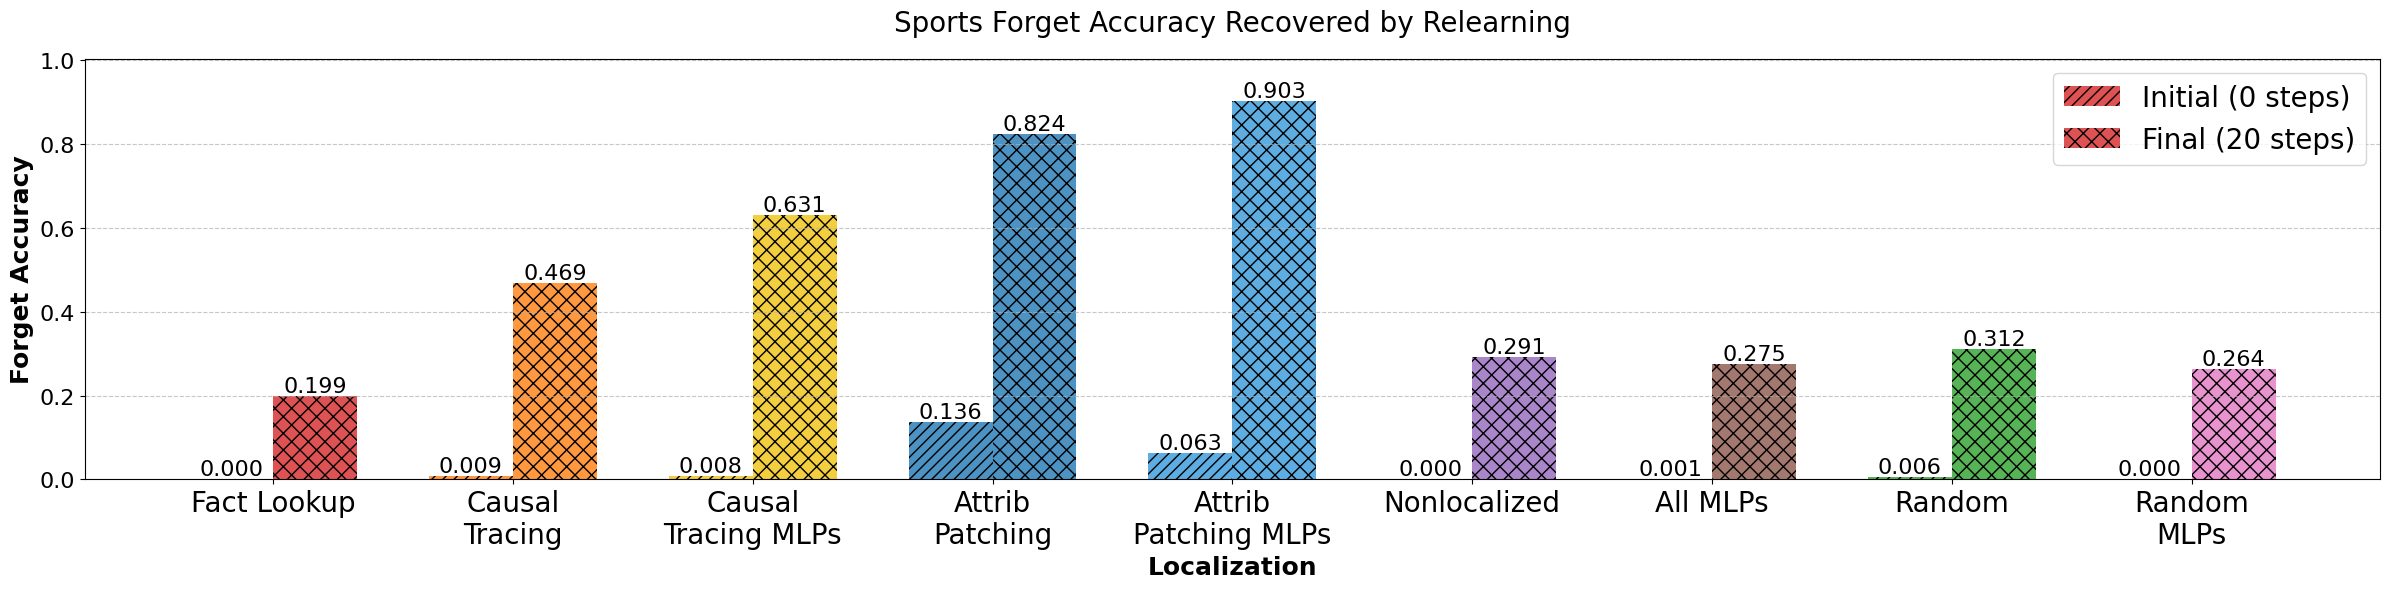

In [23]:
# Create figure
plt.figure(figsize=(24, 6))

# Width of each bar and spacing between groups
bar_width = 0.35
loc_types = list(paper_locs.keys())
x = np.arange(len(loc_types))

# Collect initial and final accuracies
initial_accuracies = []
final_accuracies = []

for loc_type in loc_types:
    data = relearning_evals_df[relearning_evals_df['localization_type'] == loc_type]
    
    # Get initial accuracy (step 0)
    initial_acc = data[data['step'] == 0]['Normal_forget'].mean()
    initial_accuracies.append(initial_acc)
    
    # Get final accuracy (step 20)
    final_acc = data[data['step'] == 20]['Normal_forget'].mean()
    final_accuracies.append(final_acc)

# Create bars with patterns
for i, loc_type in enumerate(loc_types):
    # Initial accuracy bar with diagonal pattern
    initial_bar = plt.bar(x[i] - bar_width/2, initial_accuracies[i], bar_width, 
            label='Initial (0 steps)' if i == 0 else "", 
            color=colors[loc_type],
            hatch='///',
            alpha=0.8)
    
    # Final accuracy bar with crosshatch pattern
    final_bar = plt.bar(x[i] + bar_width/2, final_accuracies[i], bar_width,
            label='Final (20 steps)' if i == 0 else "",
            color=colors[loc_type],
            hatch='xx',
            alpha=0.8)
    
    # Add value labels above bars
    plt.text(x[i] - bar_width/2, initial_accuracies[i], f'{initial_accuracies[i]:.3f}', 
             ha='center', va='bottom', fontsize=16)
    plt.text(x[i] + bar_width/2, final_accuracies[i], f'{final_accuracies[i]:.3f}', 
             ha='center', va='bottom', fontsize=16)

# Customize plot
plt.xlabel('Localization', fontsize=18, fontweight='bold')
plt.ylabel('Forget Accuracy', fontsize=18, fontweight='bold')
if "random_without_golf" in inject_labels:
    title = 'Sports Forget Accuracy Recovered by Relearning'
else:
    title = 'Sports Forget Accuracy Recovered by Relearning'
print(title)
plt.title(title, fontsize=20, pad=20)

# Set x-axis labels
paper_loc_names_with_newlines = {"Localized AP": "Attrib\nPatching", "Localized CT": "Causal\nTracing", 'Localized AP MLPs': "Attrib\nPatching MLPs",
       'Localized CT MLPs': "Causal\nTracing MLPs", 'Manual Interp': "Fact Lookup", 'Random': "Random", 'All MLPs': "All MLPs",
       'Non-Localized': "Nonlocalized", 'Random MLPs': "Random\nMLPs"}
plt.xticks(x, [paper_loc_names_with_newlines[loc] for loc in loc_types], fontsize=20)
plt.yticks(fontsize=16)
plt.ylim(0, max(final_accuracies) + 0.1)
# Add grid
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add legend
plt.legend(fontsize=20)

# Adjust layout
plt.tight_layout()

plt.show()

### Softprompt

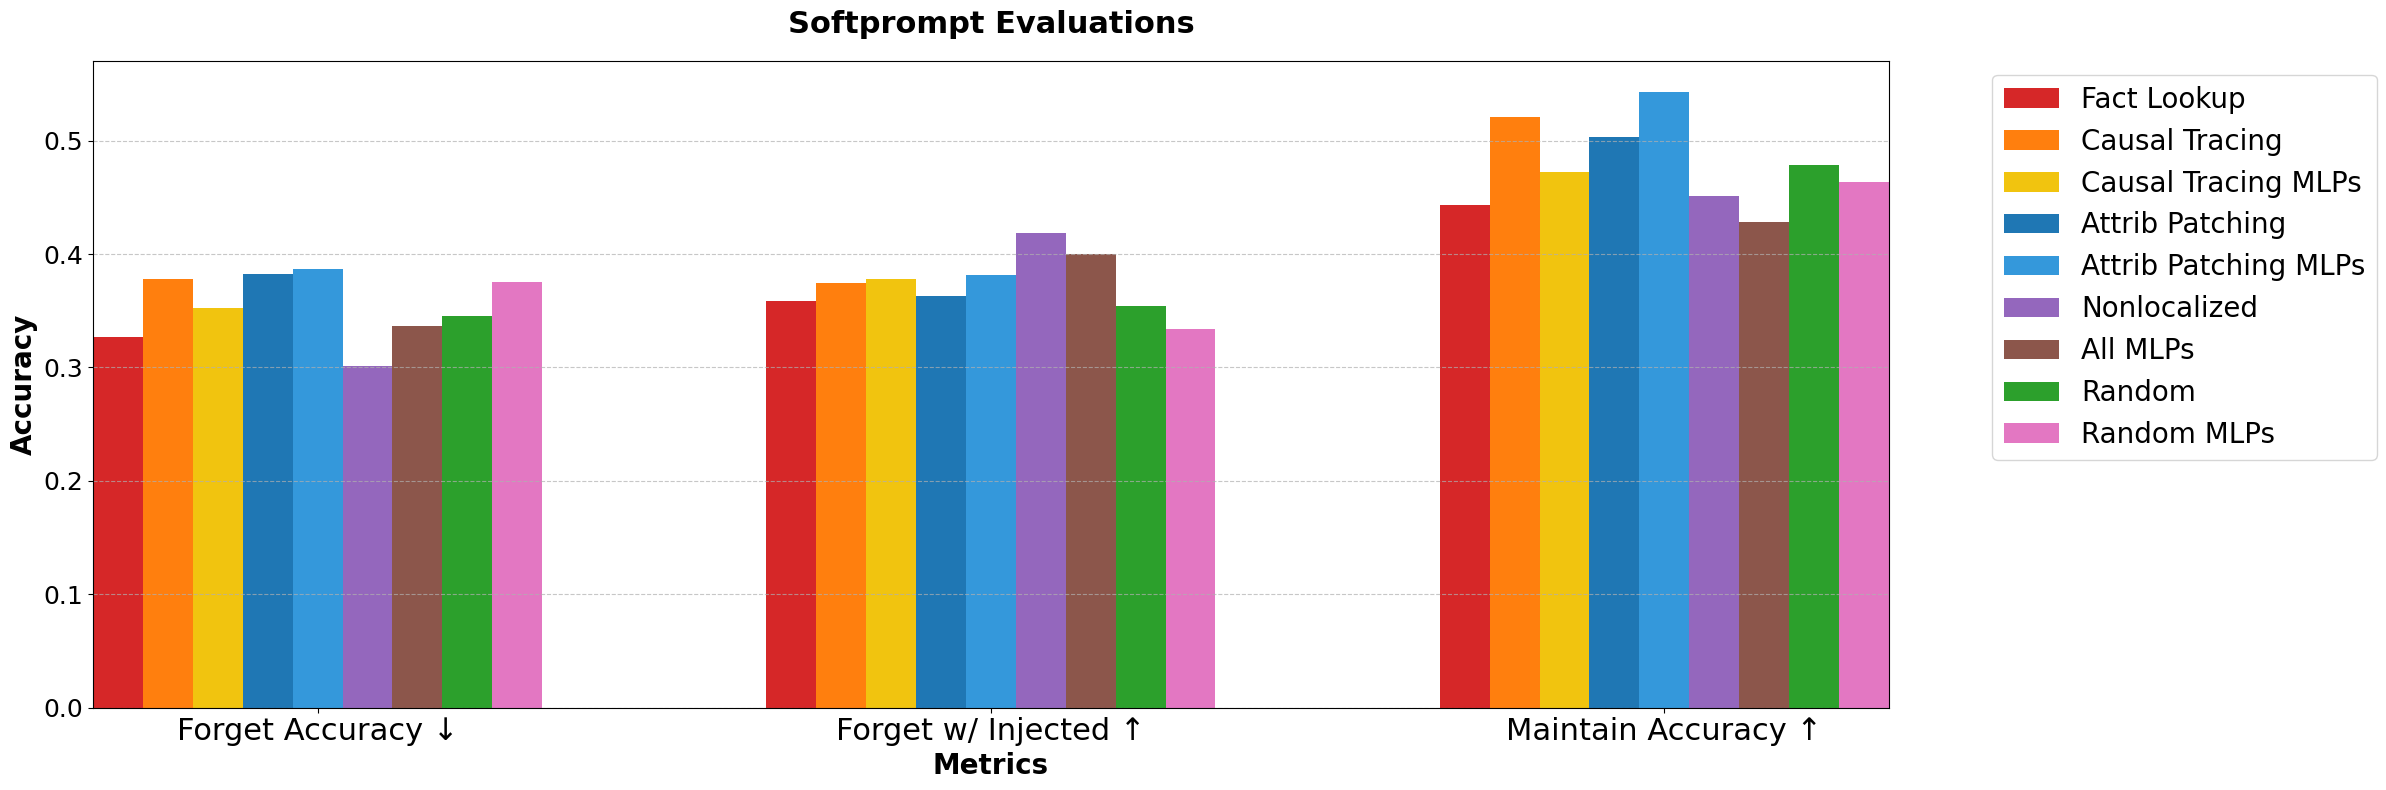

In [29]:
# Create single large figure
plt.figure(figsize=(24, 8))

# Define metrics and spacing
softprompt_metrics = ['Forget Accuracy ↓', 'Forget w/ Injected ↑', 'Maintain Accuracy ↑']
n_locs = len(paper_locs)
width = 1 / len(paper_locs)
spacing = 1.5

x = np.arange(0, len(softprompt_metrics) * spacing, spacing)

# Plot bars for each localization type
for idx, (loc_type, loc_name) in enumerate(paper_locs.items()):
    # Collect accuracies
    accuracies = []
    data = softprompt_evals_df[softprompt_evals_df['localization_type'] == loc_type]
    
    # Get the three metrics
    forget_acc = data['forget_acc'].mean()
    forget_injected_acc = data['forget_acc_with_injected'].mean()
    maintain_acc = data['maintain_acc'].mean()
    
    accuracies = [forget_acc, forget_injected_acc, maintain_acc]
    
    # Plot bars
    offset = width * (idx - n_locs/2 + 0.5)
    bars = plt.bar(x + offset, accuracies, width, label=loc_name, color=colors[loc_type])
    
    # Add value labels if needed
    if include_bar_text:
        for i, v in enumerate(accuracies):
            plt.text(x[i] + offset, v, f'{v:.3f}', ha='center', va='bottom', rotation=90, fontsize=14)

plt.xlabel('Metrics', fontsize=20, fontweight='bold')
plt.ylabel('Accuracy', fontsize=20, fontweight='bold')
plt.title("Softprompt Evaluations", fontsize=22, fontweight='bold', pad=20)

plt.xticks(x, softprompt_metrics, fontsize=22)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.xlim(min(x) - 0.5, max(x) + 0.5)

# Add legend
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

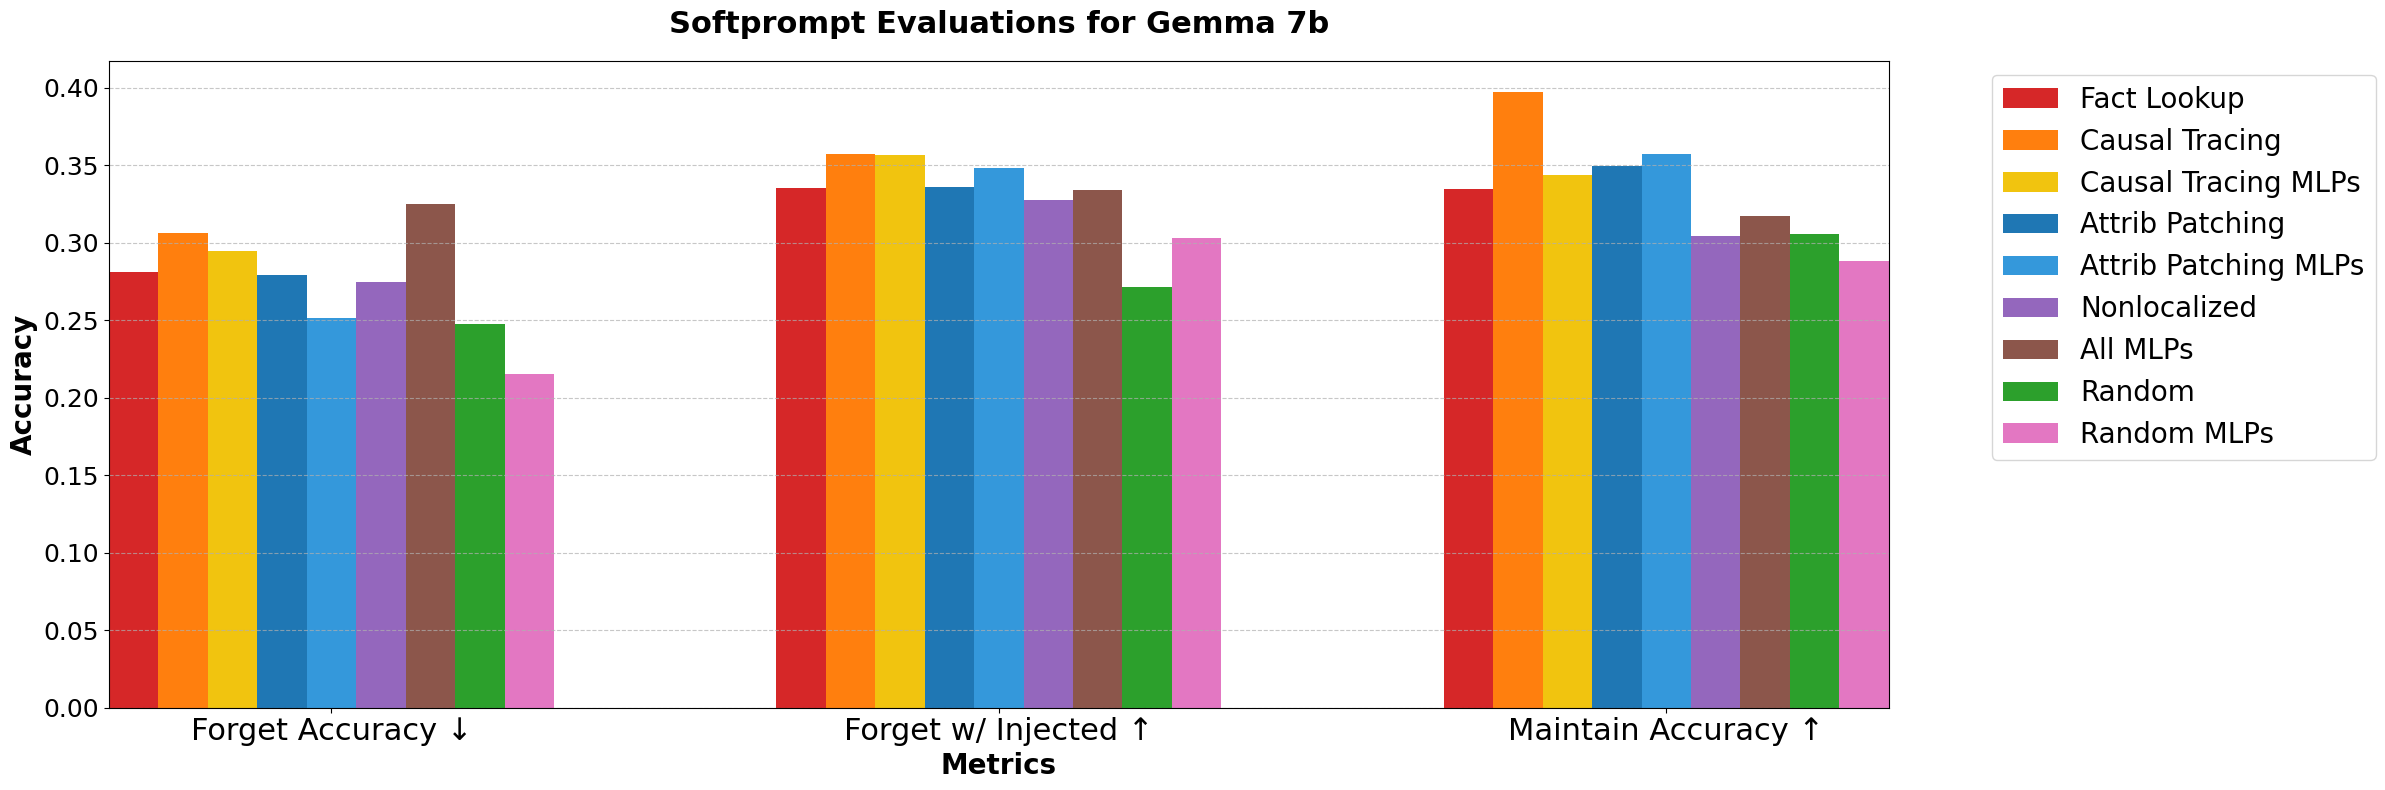

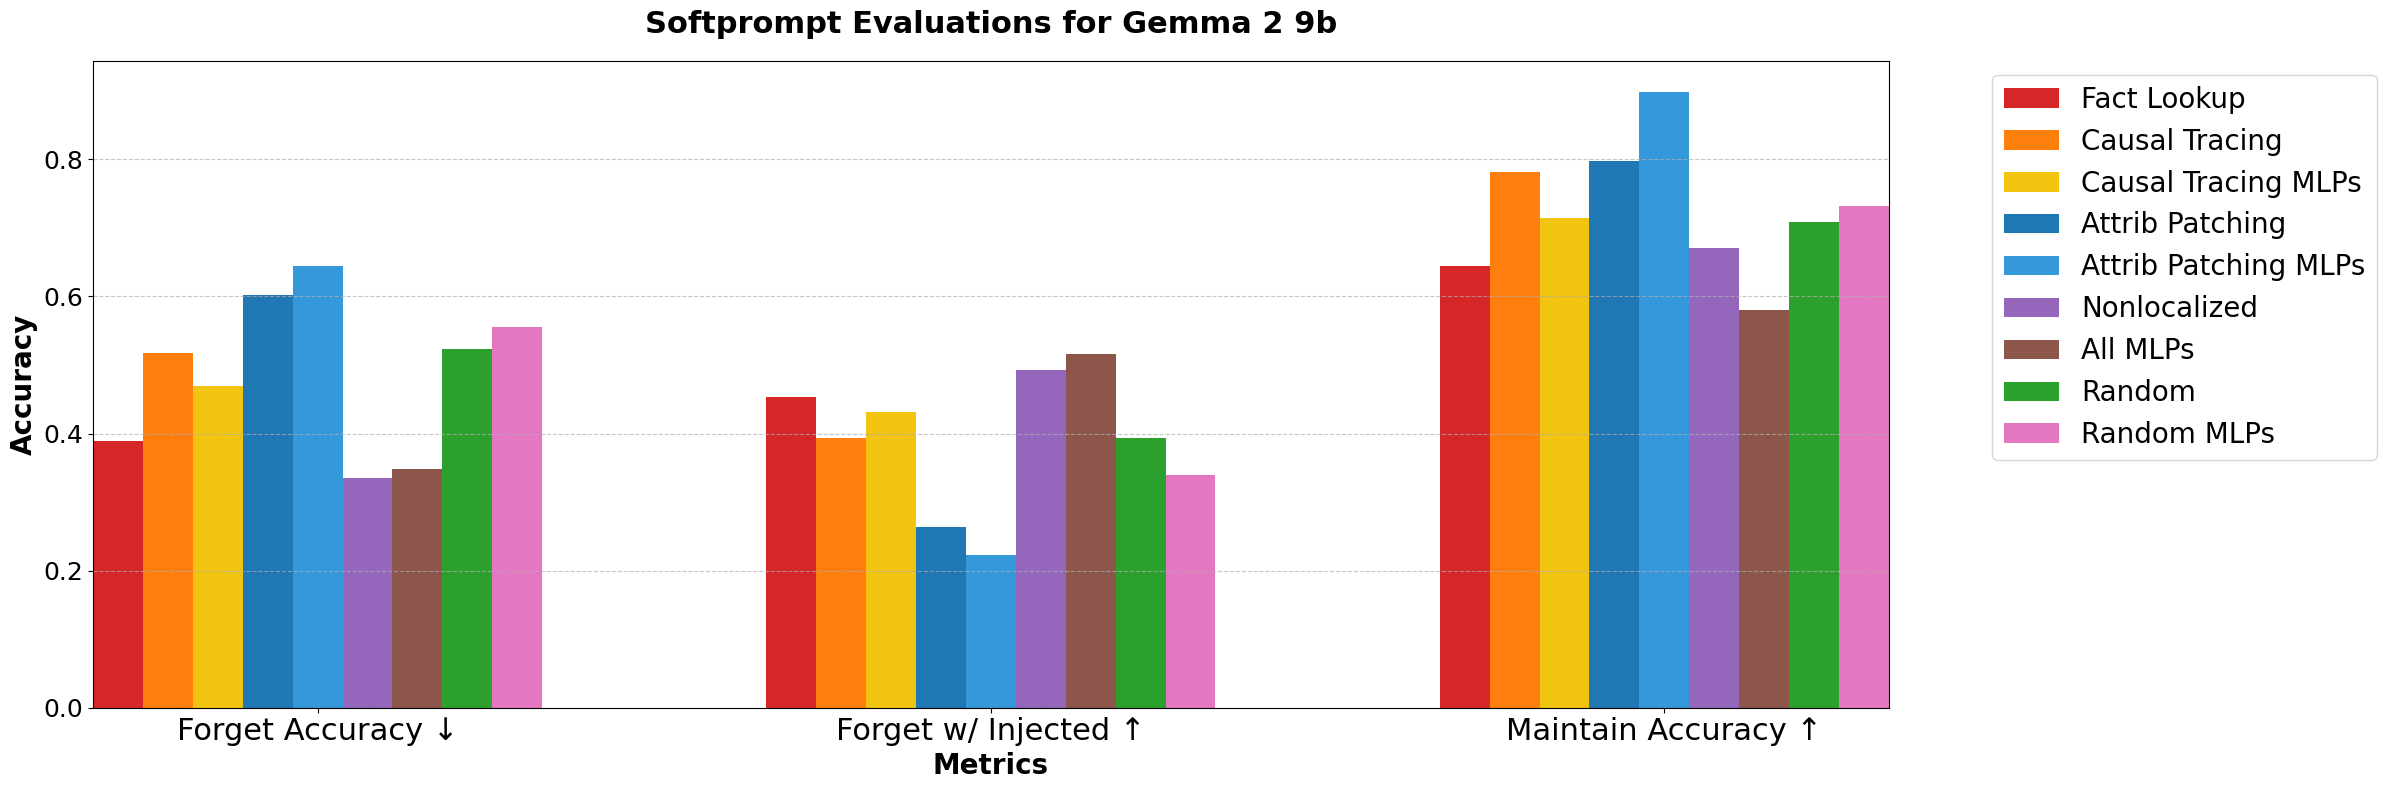

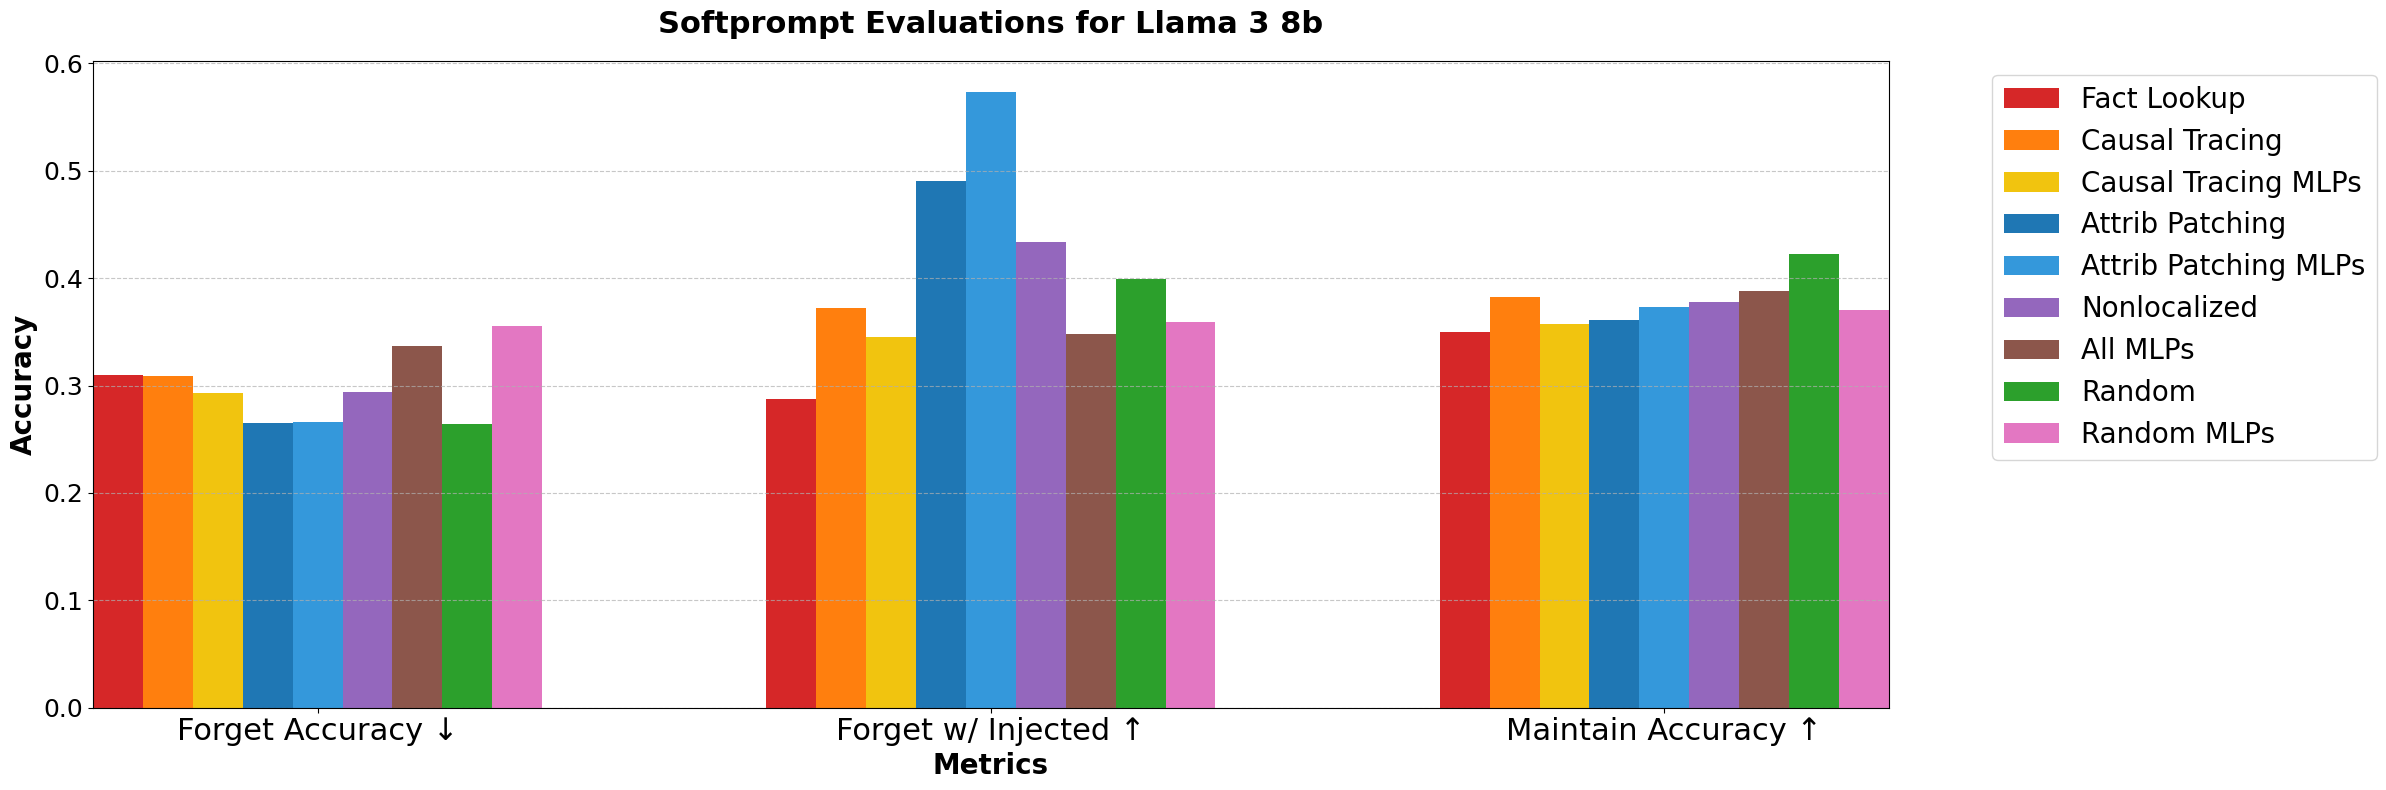

In [30]:
# Create single large figure
for model_type in model_names:
    plt.figure(figsize=(24, 8))

    # Define metrics and spacing
    softprompt_metrics = ['Forget Accuracy ↓', 'Forget w/ Injected ↑', 'Maintain Accuracy ↑']
    n_locs = len(paper_locs)
    width = 1 / len(paper_locs)
    spacing = 1.5

    x = np.arange(0, len(softprompt_metrics) * spacing, spacing)

    # Plot bars for each localization type
    for idx, (loc_type, loc_name) in enumerate(paper_locs.items()):
        # Collect accuracies
        accuracies = []
        data = softprompt_evals_df[softprompt_evals_df['localization_type'] == loc_type]
        data = data[data['model_name'] == model_type]
        
        # Get the three metrics
        forget_acc = data['forget_acc'].mean()
        forget_injected_acc = data['forget_acc_with_injected'].mean()
        maintain_acc = data['maintain_acc'].mean()
        
        accuracies = [forget_acc, forget_injected_acc, maintain_acc]
        
        # Plot bars
        offset = width * (idx - n_locs/2 + 0.5)
        bars = plt.bar(x + offset, accuracies, width, label=loc_name, color=colors[loc_type])
        
        # Add value labels if needed
        if include_bar_text:
            for i, v in enumerate(accuracies):
                plt.text(x[i] + offset, v, f'{v:.3f}', ha='center', va='bottom', rotation=90, fontsize=14)

    plt.xlabel('Metrics', fontsize=20, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=20, fontweight='bold')
    plt.title(f"Softprompt Evaluations for {model_names[model_type]}", fontsize=22, fontweight='bold', pad=20)

    plt.xticks(x, softprompt_metrics, fontsize=22)
    plt.yticks(fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.xlim(min(x) - 0.5, max(x) + 0.5)

    # Add legend
    plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()